In [92]:
# df.to_pickle('dataset_lcforest_LOF10_bin30_th3_1km_noprior_ta.pkl')

In [2]:
from scripts.parallel_blocks import *
import pandas as pd

df = pd.read_pickle('dataset_lcforest_mahal22_bin15_th3_fancy1km_noprior_ta.pkl')

df.pg.mean()

6.0306700875070405

### This can be used to adjust dataframes with a new outlier method or regression method.

In [12]:
from scripts.parallel_blocks import *
import pandas as pd

df_ = pd.read_pickle('dataset_lcforest_LOF_bin15_th3_fancy1km_noprior_ta.pkl')

# Create a column to fill later
df_['outlier'] = np.nan

# Grouping keys
group_keys = ['camera','date','lat','lon']
i=0
# Iterate over each group
for keys, test_plot in df_.groupby(group_keys):
    i+=1
    test_plot = test_plot.copy()

    try:
        coefs, _, test = df_odr(test_plot, outlier_removal=0.22, w=[1, 0.25])

        # Ensure index alignment for merging
        test_plot['outlier'] = test['Outlier'].values

        # Set the values back in the original df using index
        df_.loc[test_plot.index, 'outlier'] = test_plot['outlier']

        indices_to_insert = [i for i in range(1,7) if i not in test['beam'].unique()]

        for index in indices_to_insert:
            coefs = np.insert(coefs, index, None)

        if np.all(np.isnan([coefs[1],coefs[3],coefs[5]])):
            y_strong = np.nan
        else:
            y_strong = np.nanmean([coefs[1],coefs[3],coefs[5]])
            y_strong_max = np.nanmax([coefs[1],coefs[3],coefs[5]])
            
        if np.all(np.isnan([coefs[2],coefs[4],coefs[6]])):
            y_weak = np.nan
        else:
            y_weak = np.nanmean([coefs[2],coefs[4],coefs[6]])
            y_weak_max = np.nanmax([coefs[2],coefs[4],coefs[6]])
            
        if np.any(np.isnan([y_strong, y_weak])):
            pv_ratio_mean = np.nan
            pv_ratio_max = np.nan
        else:
            pv_ratio_mean = y_strong/y_weak
            pv_ratio_max = y_strong_max/y_weak_max
        
        y_intercept_dict = {1: coefs[1], 2: coefs[2], 3: coefs[3], 4: coefs[4], 5: coefs[5], 6: coefs[6]}
        x_intercept_dict = {1: -coefs[1]/coefs[0], 2: -coefs[2]/coefs[0], 3: -coefs[3]/coefs[0], 4: -coefs[4]/coefs[0],
                           5: -coefs[5]/coefs[0], 6: -coefs[6]/coefs[0]}

        df_.loc[test_plot.index,'pvpg'] = -coefs[0]
        df_.loc[test_plot.index,'pv'] = test_plot['beam'].map(y_intercept_dict)
        df_.loc[test_plot.index,'pg'] = test_plot['beam'].map(x_intercept_dict)
        df_.loc[test_plot.index,'pv_ratio_max'] = pv_ratio_max
        df_.loc[test_plot.index,'pv_ratio_mean'] = pv_ratio_mean

    except Exception as e:
        print(f"Skipping group {keys} due to error: {e}")
        continue

    # print(params)
    # print(test_plot)
    # print(test)

# All 18 Sites!

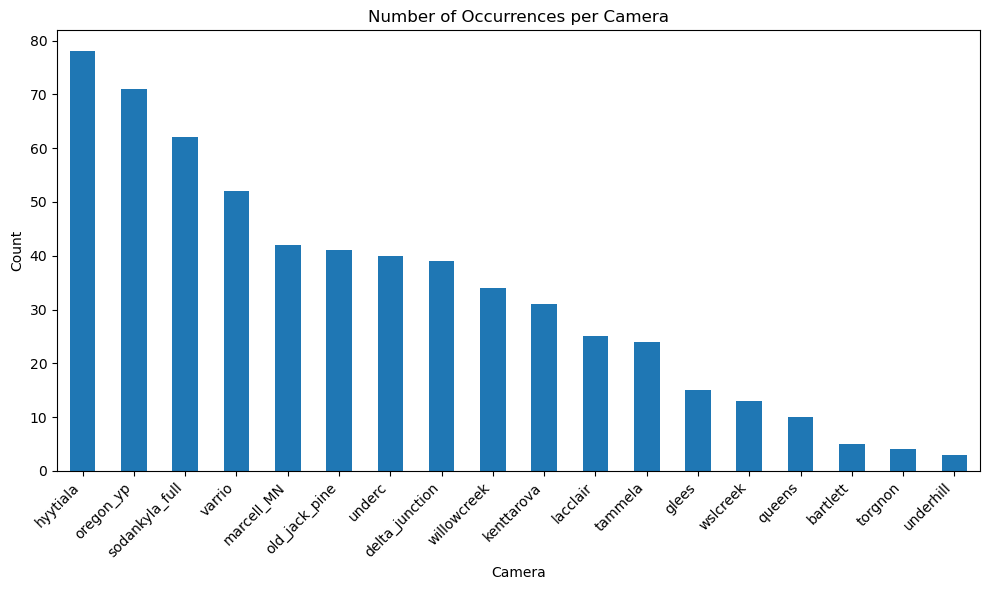

In [18]:
# Assuming your dataframe is called `data`
counts = data['camera'].value_counts()

plt.figure(figsize=(10, 6))
counts.plot(kind='bar')
plt.xlabel('Camera')
plt.ylabel('Count')
plt.title('Number of Occurrences per Camera')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

1819


/tmp/ipykernel_2596348/1457692846.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Conditions"] = data["JointSnow"].map({0: "No Snow", 1: "Ground Snow", 2: "Ground and Canopy Snow"})


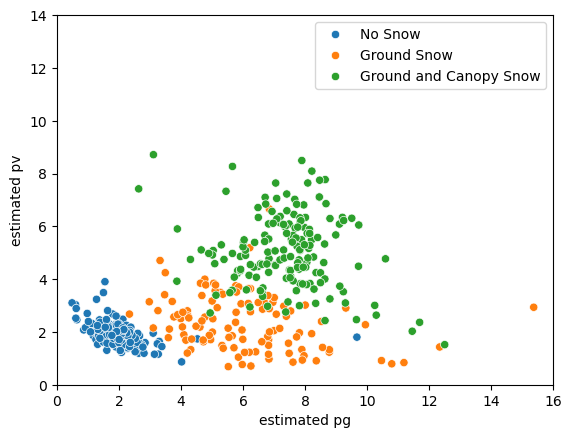

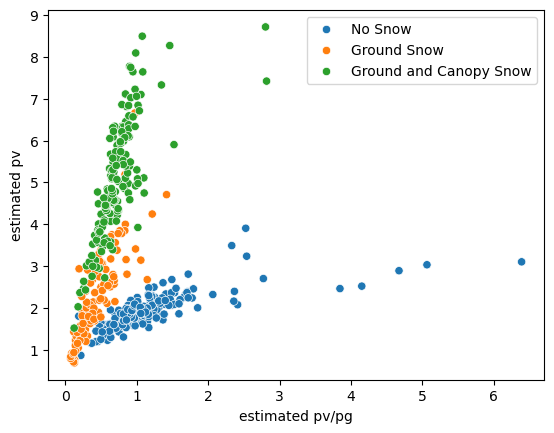

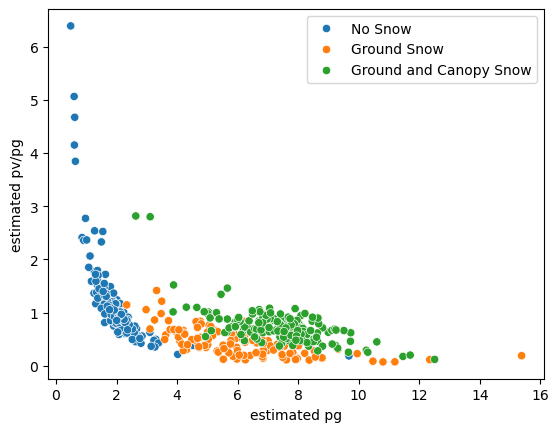

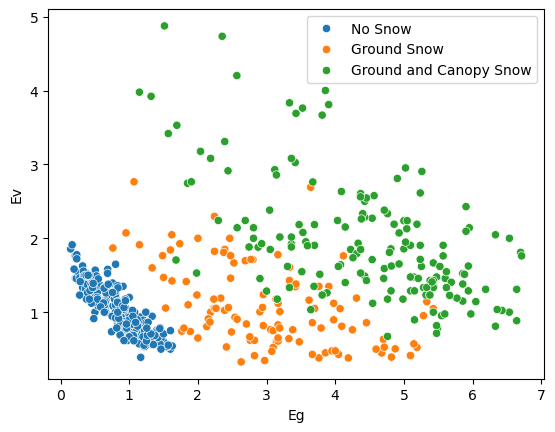

In [1]:
from scripts.imports import *

df = pd.read_pickle('dataset_lcforest_LOF_bin15_th3_fancy1km_noprior_ta.pkl')
# df = pd.read_pickle('dataset_lcforest_LOF_bin15_th3_fancy750m_noprior_ta.pkl')

# df = df_.copy()
# print(df)
# mask = df['beam'] == 3
# df.loc[mask, ['pv','pg','Ev','Eg']] /= 0.85

# First create masked columns
df['Eg_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier'] == 1), df['Eg'], np.nan)
df['Ev_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier'] == 1), df['Ev'], np.nan)
df['Eg_weak'] = np.where((df['beam_str'] == 'weak')&(df['outlier'] == 1), df['Eg'], np.nan)
df['Ev_weak'] = np.where((df['beam_str'] == 'weak')&(df['outlier'] == 1), df['Ev'], np.nan)

df_grouped = df.groupby(['camera','date','lat','lon']).agg({
    'pvpg': 'mean',
    'pv': 'max',
    'pg': 'max',
    'Eg_strong': 'median',
    'Ev_strong': 'median',
    'Eg_weak': 'median',
    'Ev_weak': 'median',
    'data_quantity': 'max',
    'snr': 'mean',
    'FSC': 'mean',
    'TreeSnow': 'mean',
    'layer_flag': 'mean',
    'file_index': 'mean',
    'msw_flag': 'mean',
    'pv_ratio_mean': 'mean',
    'pv_ratio_max': 'mean',
}).reset_index()
df_grouped = df_grouped[df_grouped['Eg_strong']>=0]
print(len(df_grouped[((df_grouped['FSC'] <= 0.05)|(df_grouped['FSC'] >= 0.95))]))
df_grouped['JointSnow'] = df_grouped['FSC'] + df_grouped['TreeSnow']
data = df_grouped[((df_grouped['FSC'] <= 0.05)|(df_grouped['FSC'] >= 0.95))
    &(df_grouped['pv'] <= 16)&(df_grouped['pg'] <= 16)&(df_grouped['pvpg'] <= 7.5)
    # &(df_grouped['pv_ratio_mean'] >= 1.2)
    &(df_grouped['Eg_strong']/df_grouped['Eg_weak'] >= 1.1)#&(df_grouped['Ev_strong']/df_grouped['Ev_weak'] >= 1.1)
    &((df_grouped['layer_flag'] <= .7)&(df_grouped['msw_flag'] < 0.2))&(df_grouped['data_quantity'] >= 27)]
data.loc[:, 'JointSnow'] = data['JointSnow'].apply(lambda x: np.round(x))

data["Conditions"] = data["JointSnow"].map({0: "No Snow", 1: "Ground Snow", 2: "Ground and Canopy Snow"})

plt.figure()
sns.scatterplot(data = data.sort_values('JointSnow'), x='pg', y='pv', hue='Conditions')#, size='data_quantity')
plt.xlabel('estimated pg')
plt.ylabel('estimated pv')
plt.xlim(0,16)
plt.ylim(0,14)
# plt.plot([4.2,0],[0,9],'r--') #LOF10_bin20_DW 570 points
# plt.plot([5,0],[0,7.5],'r--') #LOF10_bin30_DW 596 points
                                #LOF10_bin20 578 points
plt.legend(loc='best')
plt.show()

plt.figure()
sns.scatterplot(data = data.sort_values('JointSnow'), x='pvpg', y='pv', hue='Conditions')#, size='data_quantity')
plt.xlabel('estimated pv/pg')
plt.ylabel('estimated pv')
# plt.xlim(0,3)
# plt.ylim(0,12)
plt.legend(loc='best')
plt.show()

plt.figure()
sns.scatterplot(data = data.sort_values('JointSnow'), x='pg', y='pvpg', hue='Conditions')#, size='data_quantity')
plt.xlabel('estimated pg')
plt.ylabel('estimated pv/pg')
# plt.xlim(0,20)
# plt.ylim(0,20)
plt.legend(loc='best')
plt.show()

plt.figure()
sns.scatterplot(data = data.sort_values('JointSnow'), x='Eg_strong', y='Ev_strong', hue='Conditions')#, size='data_quantity')
plt.xlabel('Eg')
plt.ylabel('Ev')
# plt.xlim(0,20)
# plt.ylim(0,20)
# plt.plot([2.5,0],[0,2.5],'r--') #LOF10_bin20 570 points
# plt.plot([2.5,0],[0,2.5],'r--') #LOF10_bin30 596 points
plt.legend(loc='best')
plt.show()

#### Logistic Regression

In [4]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
# from sklearn.linear_model import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Assuming your dataframe is called df
# features = ['pvpg', 'pv', 'pg', 'snr', 'pv_ratio_mean', 'pv_ratio_max']
features = ['Ev_strong','Eg_strong']#,'pv', 'pg', 'pvpg']
target = 'JointSnowBinary'

data['JointSnowBinary'] = data['JointSnow'].apply(lambda x: 0 if x == 0 else 1)

X = data[features]
y = data[target]

# Optional: standardize the features (helps logistic regression perform better)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit logistic regression on all data
model = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42, penalty=None)
model.fit(X_scaled, y)

# Predict on the same data (since you said to use all data)
y_pred = model.predict(X_scaled)

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred))
print("\nClassification Report:")
print(classification_report(y, y_pred))

# Get boolean mask of incorrect predictions
incorrect_mask = y != y_pred

# Optionally convert y to numpy array if needed
# y = y.to_numpy()

# Get the misclassified rows from the original dataframe
misclassified = data[incorrect_mask]

# Add true and predicted labels to the misclassified DataFrame for inspection
misclassified = misclassified.copy()
misclassified['TrueLabel'] = y[incorrect_mask]
misclassified['PredictedLabel'] = y_pred[incorrect_mask]

# Show the result
misclassified.sort_values(['JointSnow','camera','date'])

Confusion Matrix:
[[223   0]
 [  0 279]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       223
           1       1.00      1.00      1.00       279

    accuracy                           1.00       502
   macro avg       1.00      1.00      1.00       502
weighted avg       1.00      1.00      1.00       502



/tmp/ipykernel_854132/2964566048.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['JointSnowBinary'] = data['JointSnow'].apply(lambda x: 0 if x == 0 else 1)


,camera,date,lat,lon,pvpg,pv,pg,Eg_strong,Ev_strong,Eg_weak,...,layer_flag,file_index,msw_flag,pv_ratio_mean,pv_ratio_max,JointSnow,Conditions,JointSnowBinary,TrueLabel,PredictedLabel


#### Linear function of pv and pg

In [16]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
# from sklearn.linear_model import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Assuming your dataframe is called df
# features = ['pvpg', 'pv', 'pg', 'snr', 'pv_ratio_mean', 'pv_ratio_max']
features = ['pv', 'pg', 'pvpg']#,'Ev_strong','Eg_strong',]
target = 'JointSnowBinary'

data['JointSnowBinary'] = data['JointSnow'].apply(lambda x: 0 if x == 0 else 1)

X = data[features]
y = data[target]

# Optional: standardize the features (helps logistic regression perform better)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit logistic regression on all data
model = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42, penalty=None)
model.fit(X_scaled, y)

# Predict on the same data (since you said to use all data)
y_pred = model.predict(X_scaled)

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred))
print("\nClassification Report:")
print(classification_report(y, y_pred))

# Get boolean mask of incorrect predictions
incorrect_mask = y != y_pred

# Optionally convert y to numpy array if needed
# y = y.to_numpy()

# Get the misclassified rows from the original dataframe
misclassified = data[incorrect_mask]

# Add true and predicted labels to the misclassified DataFrame for inspection
misclassified = misclassified.copy()
misclassified['TrueLabel'] = y[incorrect_mask]
misclassified['PredictedLabel'] = y_pred[incorrect_mask]

# Show the result
misclassified.sort_values(['JointSnow','camera','date'])

Confusion Matrix:
[[282   4]
 [ 12 257]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       286
           1       0.98      0.96      0.97       269

    accuracy                           0.97       555
   macro avg       0.97      0.97      0.97       555
weighted avg       0.97      0.97      0.97       555



/tmp/ipykernel_362537/3029202463.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['JointSnowBinary'] = data['JointSnow'].apply(lambda x: 0 if x == 0 else 1)


,camera,date,lat,lon,pvpg,pv,pg,Eg_strong,Ev_strong,data_quantity,...,layer_flag,file_index,msw_flag,pv_ratio_mean,pv_ratio_max,JointSnow,Conditions,JointSnowBinary,TrueLabel,PredictedLabel
2676,underc,07/05/2019,46.227143,-89.579656,0.083312,1.323971,15.891767,4.313725,0.904977,23.000000,...,0.0,0.0,0.0,NaN,NaN,0.0,No Snow,0,0,1
2854,underhill,07/11/2021,44.527252,-72.846087,0.555310,2.149833,3.871414,0.816176,1.552778,23.620690,...,0.0,5.0,0.0,1.415580,1.415580,0.0,No Snow,0,0,1
3117,willowcreek,05/09/2020,45.817261,-90.051450,0.174904,1.800639,10.294989,1.578947,1.571429,31.129032,...,0.0,7.0,0.0,1.975942,1.975942,0.0,No Snow,0,0,1
3241,willowcreek,15/06/2019,45.839784,-90.060042,0.137783,1.795168,13.028996,2.441176,1.512605,32.000000,...,0.0,3.0,0.0,NaN,NaN,0.0,No Snow,0,0,1
95,bartlett,31/01/2021,44.075861,-71.243271,3.376928,3.759916,1.113413,0.533333,1.866667,22.714286,...,0.0,6.0,0.0,1.182391,1.182391,1.0,Ground Snow,1,1,0
347,delta_junction,30/04/2022,63.869839,-145.788221,0.436778,1.901914,4.354419,3.193277,0.470588,23.391304,...,0.0,19.0,0.0,1.642809,1.642809,1.0,Ground Snow,1,1,0
348,delta_junction,30/04/2022,63.874343,-145.789414,0.420834,1.805265,4.289736,2.043344,0.825593,25.980392,...,0.0,19.0,0.0,1.975319,1.975319,1.0,Ground Snow,1,1,0
1130,marcell_MN,20/03/2022,47.538684,-93.439705,0.325965,1.480065,4.540564,1.872368,0.830144,22.409091,...,0.0,16.0,0.0,1.832224,1.832224,1.0,Ground Snow,1,1,0
1263,marcell_MN,30/10/2020,47.489134,-93.474873,0.376562,1.505988,3.999315,1.564474,0.973684,24.459459,...,0.0,9.0,0.0,1.824053,1.824053,1.0,Ground Snow,1,1,0
3242,willowcreek,28/02/2024,45.772216,-90.076248,0.113407,0.854146,7.531654,3.413095,0.418831,28.529412,...,0.0,17.0,0.0,1.702053,1.702053,1.0,Ground Snow,1,1,0


# Plotting ATL08 from the Dataframe

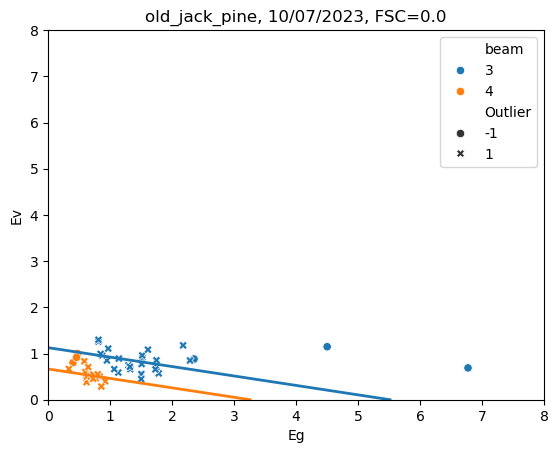

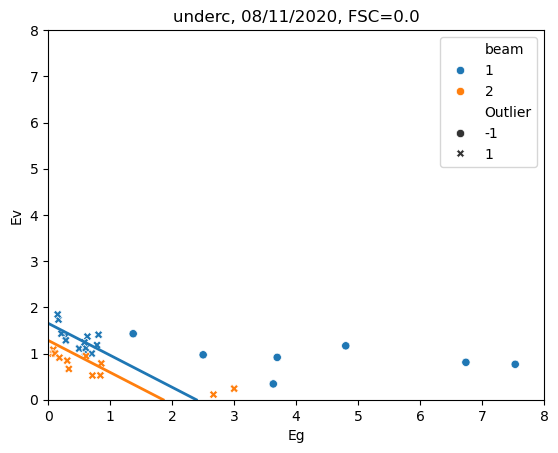

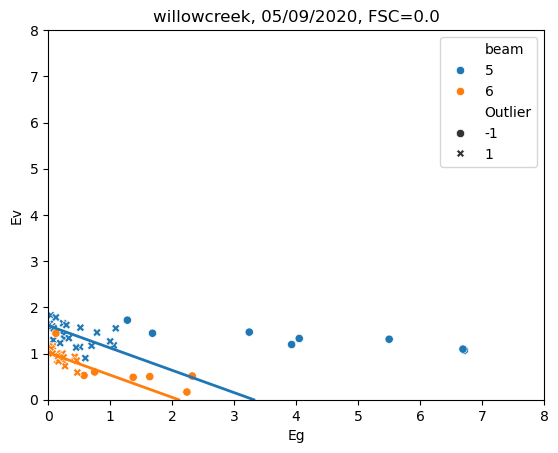

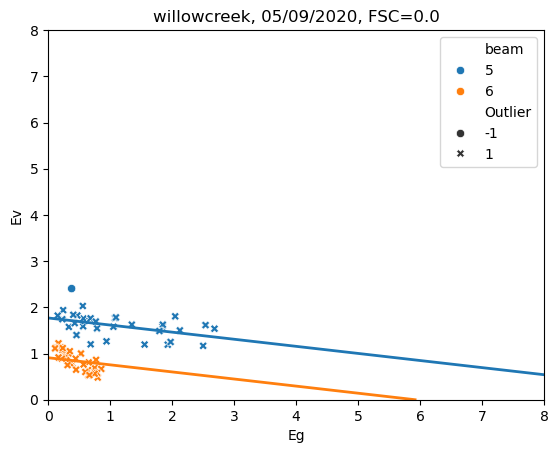

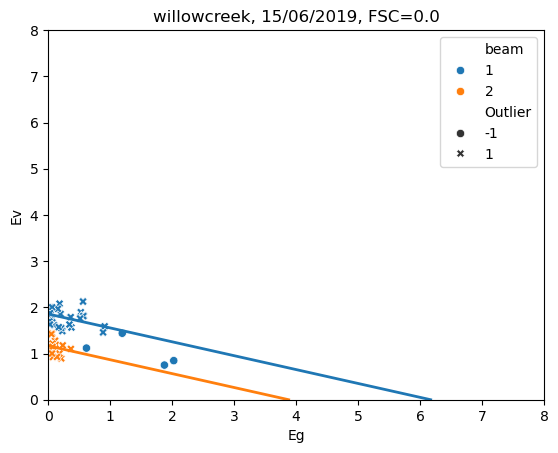

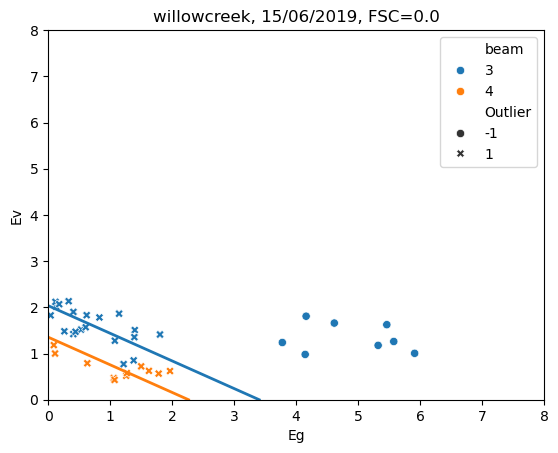

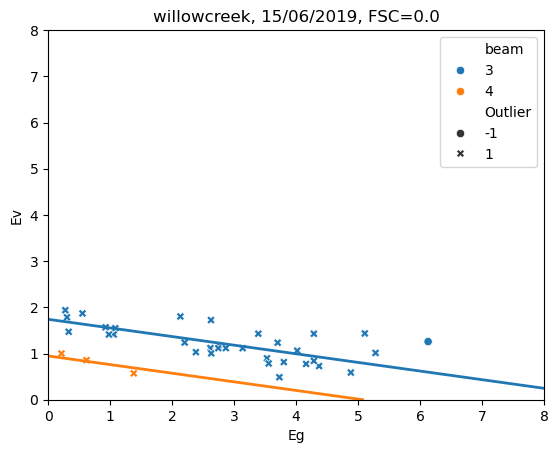

In [11]:
from scripts.parallel_blocks import *
    
# misclassified.columns
for idx, row in misclassified.iterrows():
    if row['FSC'] <= 0.05:
        plt.figure()
        plt.title(f"{row['camera']}, {row['date']}, FSC={row['FSC']}")
        
        test_plot = df[(df['camera'] == row['camera']) &
                       (df['date'] == row['date']) &
                       (df['lon'] == row['lon']) &
                       (df['lat'] == row['lat'])].copy()

        params, _, test = df_odr(test_plot, outlier_removal=10,w=[1, 0.25])

        # print(test)

        # Get sorted unique beams (hue order used by seaborn)
        beam_order = sorted(test['beam'].unique())

        # Create mapping from beam label to tab10 color
        tab10 = cm.get_cmap('tab10')
        color_map = {beam: tab10(i) for i, beam in enumerate(beam_order)}

        # Plot with fixed hue order and palette
        sns.scatterplot(data=test, x='Eg', y='Ev', hue='beam', style='Outlier',
                        hue_order=beam_order, palette=color_map)

        # Plot ODR lines in matching colors
        for b, beam in zip(params[1:], beam_order):
            plt.plot([0, -b / params[0]], [b, 0], color=color_map[beam], linewidth=2)

        plt.xlim(0, 8)
        plt.ylim(0, 8)
        plt.legend()
        plt.show()

        # break

# Fractional

/tmp/ipykernel_861562/1692945481.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frac_data['JointSnowBinary'] = frac_data['JointSnow'].apply(lambda x: 1 if x >= 1 else x)


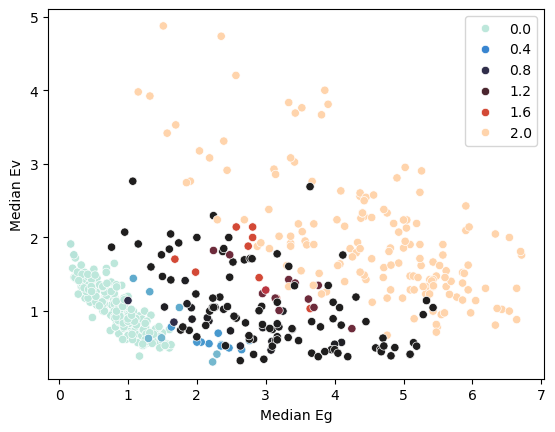

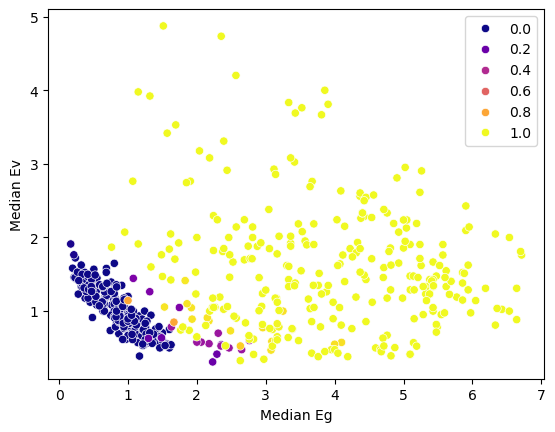

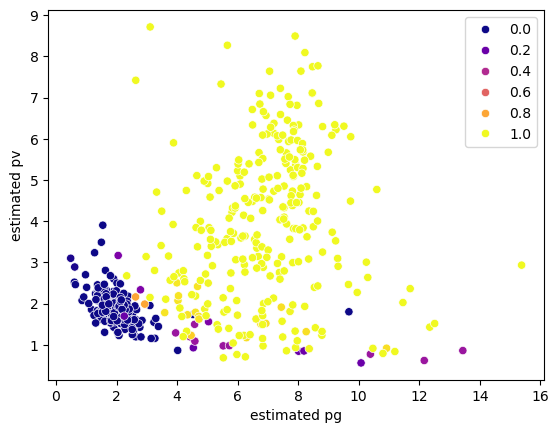

522


,camera,date,lat,lon,pvpg,pv,pg,Eg_strong,Ev_strong,Eg_weak,...,snr,FSC,TreeSnow,layer_flag,file_index,msw_flag,pv_ratio_mean,pv_ratio_max,JointSnow,JointSnowBinary
713,marcell_MN,30/04/2021,47.518414,-93.407102,0.851248,1.801006,2.115725,0.941176,1.000000,0.585714,...,2.114199,0.0,0.0,0.0,12.0,0.0,1.357232,1.357232,0.0,0.0
1244,sodankyla_full,14/06/2019,67.357328,26.553078,2.525340,3.903240,1.545630,1.303309,0.569118,0.250000,...,0.921305,0.0,0.0,0.0,5.0,0.0,2.089993,2.089993,0.0,0.0
1219,sodankyla_full,10/09/2020,67.339310,26.546794,1.045783,1.664825,1.591941,0.866667,0.692308,0.535714,...,10.452248,0.0,0.0,0.0,13.0,0.0,1.296011,1.296011,0.0,0.0
1221,sodankyla_full,10/09/2020,67.357328,26.552688,1.033964,1.768365,1.710277,1.230769,0.538462,0.666667,...,9.724996,0.0,0.0,0.0,13.0,0.0,1.423078,1.423078,0.0,0.0
1222,sodankyla_full,10/09/2020,67.366338,26.554528,0.951227,1.579736,1.660735,0.972222,0.618056,0.500000,...,8.817569,0.0,0.0,0.0,13.0,0.0,1.490352,1.490352,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1960,wslcreek,31/10/2019,39.877886,-105.893161,1.344493,7.327947,5.450341,1.512605,4.873950,0.394737,...,0.545319,1.0,1.0,0.0,4.0,0.0,3.192853,3.192853,2.0,1.0
1962,wslcreek,31/10/2019,39.895905,-105.890706,0.787511,6.176960,7.843649,4.565826,2.577031,0.357585,...,0.604666,1.0,1.0,0.0,4.0,0.0,2.745920,2.745920,2.0,1.0
1964,wslcreek,31/10/2019,39.913923,-105.888413,1.461030,8.268936,5.659664,2.566845,4.201681,0.542484,...,0.539841,1.0,1.0,0.0,4.0,0.0,3.138918,3.138918,2.0,1.0
1965,wslcreek,31/10/2019,39.922932,-105.887302,0.884344,6.835809,7.729812,2.352941,4.733894,0.450000,...,0.338189,1.0,1.0,0.0,4.0,0.0,2.997035,2.997035,2.0,1.0


In [8]:
from scripts.imports import *

df = pd.read_pickle('dataset_lcforest_LOF_bin15_th3_fancy1km_noprior_ta.pkl')
# print(df.columns)

df['Eg_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier']==1), df['Eg'], np.nan)
df['Ev_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier']==1), df['Ev'], np.nan)
df['Eg_weak'] = np.where((df['beam_str'] == 'weak')&(df['outlier'] == 1), df['Eg'], np.nan)
df['Ev_weak'] = np.where((df['beam_str'] == 'weak')&(df['outlier'] == 1), df['Ev'], np.nan)

df_grouped = df.groupby(['camera','date','lat','lon']).agg({
    'pvpg': 'mean',
    'pv': 'max',
    'pg': 'max',
    'Eg_strong': 'median',
    'Ev_strong': 'median',
    'Eg_weak': 'median',
    'Ev_weak': 'median',
    'data_quantity': 'max',
    'snr': 'mean',
    'FSC': 'mean',
    'TreeSnow': 'mean',
    'layer_flag': 'mean',
    'file_index': 'mean',
    'msw_flag': 'mean',
    'pv_ratio_mean': 'mean',
    'pv_ratio_max': 'mean',
}).reset_index()
df_grouped = df_grouped[df_grouped['Eg_strong']>=0]
df_grouped['JointSnow'] = df_grouped['FSC'] + df_grouped['TreeSnow']
frac_data = df_grouped[((df_grouped['FSC'] >= 0.00)&(df_grouped['FSC'] <= 1.00))
    &(df_grouped['pv'] <= 16)&(df_grouped['pg'] <= 16)&(df_grouped['pvpg'] <= 7.5)
    # &(df_grouped['pv_ratio_mean'] >= 1.2)
    &(df_grouped['Eg_strong']/df_grouped['Eg_weak'] >= 1.2)#&(df_grouped['Ev_strong']/df_grouped['Ev_weak'] >= 1.1)
    &((df_grouped['layer_flag'] <= .7)&(df_grouped['msw_flag'] < 0.2))&(df_grouped['data_quantity'] >= 27)]
frac_data['JointSnowBinary'] = frac_data['JointSnow'].apply(lambda x: 1 if x >= 1 else x)

plt.figure()
sns.scatterplot(data = frac_data.sort_values('FSC'), x='Eg_strong', y='Ev_strong', hue='JointSnow', palette='icefire')
plt.xlabel('Median Eg')
plt.ylabel('Median Ev')
# plt.xlim(0,16)
# plt.ylim(0,14)
# plt.plot([0,2.5],[1.32,5],'r--')
# plt.plot([0,2.5],[1.3,6.4],'r--')
plt.legend(loc='best')
plt.show()

plt.figure()
sns.scatterplot(data = frac_data.sort_values('FSC'), x='Eg_strong', y='Ev_strong', hue='JointSnowBinary', palette='plasma')
plt.xlabel('Median Eg')
plt.ylabel('Median Ev')
# plt.xlim(0,16)
# plt.ylim(0,14)
# plt.plot([0,2.5],[1.32,5],'r--')
# plt.plot([0,2.5],[1.3,6.4],'r--')
plt.legend(loc='best')
plt.show()

plt.figure()
sns.scatterplot(data = frac_data.sort_values('FSC'), x='pg', y='pv', hue='JointSnowBinary', palette='plasma')#, size='data_quantity')
plt.xlabel('estimated pg')
plt.ylabel('estimated pv')
# plt.xlim(0,16)
# plt.ylim(0,14)
# plt.plot([0,2.5],[1.32,5],'r--')
# plt.plot([0,2.5],[1.3,6.4],'r--')
plt.legend(loc='best')
plt.show()

print(len(frac_data))
frac_data.sort_values('FSC')

/tmp/ipykernel_861562/4004111171.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frac_data['JointSnowBinary'] = frac_data['JointSnow'].apply(lambda x: 1 if x >= 1 else x)


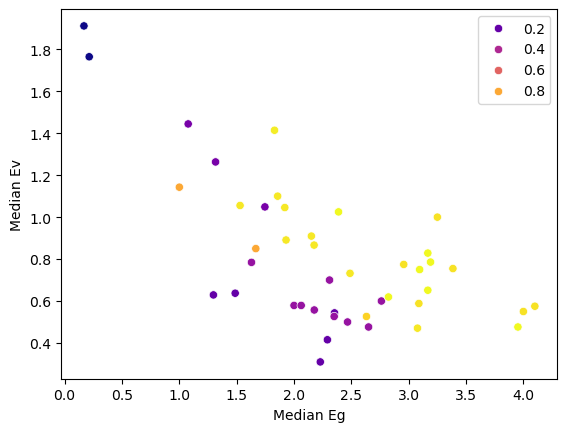

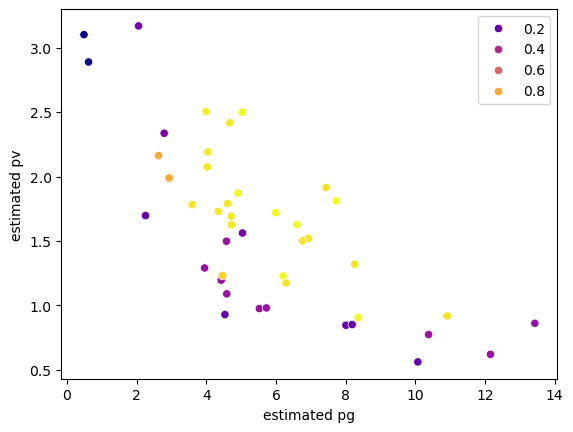

44


,camera,date,lat,lon,pvpg,pv,pg,Eg_strong,Ev_strong,Eg_weak,...,snr,FSC,TreeSnow,layer_flag,file_index,msw_flag,pv_ratio_mean,pv_ratio_max,JointSnow,JointSnowBinary
1914,wslcreek,23/10/2023,39.913923,-105.903778,6.389692,3.100944,0.485304,0.168067,1.911765,0.111111,...,0.373098,0.02,0.0,0.000000,14.0,0.0,1.622604,1.622604,0.02,0.02
1911,wslcreek,23/10/2023,39.895905,-105.905789,4.672310,2.888945,0.618312,0.213904,1.764706,0.118056,...,0.357741,0.02,0.0,0.000000,14.0,0.0,1.572030,1.572030,0.02,0.02
71,delta_junction,02/05/2021,63.867586,-145.769149,0.105647,0.846117,8.008945,2.352941,0.543344,0.944444,...,0.866235,0.20,0.0,0.000000,16.0,0.0,1.613743,1.613743,0.20,0.20
72,delta_junction,02/05/2021,63.876595,-145.771246,0.204834,0.928807,4.534446,2.291022,0.415225,0.928571,...,0.841385,0.20,0.0,0.000000,16.0,0.0,1.463351,1.463351,0.20,0.20
73,delta_junction,02/05/2021,63.885605,-145.773318,0.055724,0.561393,10.074529,2.229102,0.309598,0.883117,...,0.859275,0.20,0.0,0.000000,16.0,0.0,0.812037,0.812037,0.20,0.20
158,delta_junction,26/04/2024,63.876595,-145.756934,0.752970,1.696849,2.253542,1.486842,0.637218,0.436508,...,0.303764,0.20,0.0,0.000000,32.0,0.0,1.380338,1.380338,0.20,0.20
152,delta_junction,26/04/2024,63.849568,-145.750302,0.103964,0.851402,8.189417,1.297059,0.629085,0.200000,...,0.270098,0.20,0.0,0.000000,32.0,0.0,1.026356,1.026356,0.20,0.20
81,delta_junction,03/05/2020,63.876595,-145.805841,1.543325,3.168583,2.053089,1.076923,1.444444,0.400000,...,0.252075,0.25,0.0,0.000000,8.0,0.0,1.895639,1.895639,0.25,0.25
86,delta_junction,03/05/2020,63.894614,-145.809919,0.310046,1.561783,5.037266,1.746032,1.048810,0.333333,...,0.292784,0.25,0.0,0.000000,8.0,0.0,1.467422,1.467422,0.25,0.25
83,delta_junction,03/05/2020,63.885605,-145.807932,0.837430,2.335950,2.789429,1.315789,1.263158,0.125000,...,0.273962,0.25,0.0,0.000000,8.0,0.0,1.775302,1.775302,0.25,0.25


In [2]:
from scripts.imports import *

df = pd.read_pickle('dataset_lcforest_LOF_bin15_th3_fancy1km_noprior_ta.pkl')
# print(df.columns)

df['Eg_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier']==1), df['Eg'], np.nan)
df['Ev_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier']==1), df['Ev'], np.nan)
df['Eg_weak'] = np.where((df['beam_str'] == 'weak')&(df['outlier'] == 1), df['Eg'], np.nan)
df['Ev_weak'] = np.where((df['beam_str'] == 'weak')&(df['outlier'] == 1), df['Ev'], np.nan)

df_grouped = df.groupby(['camera','date','lat','lon']).agg({
    'pvpg': 'mean',
    'pv': 'max',
    'pg': 'max',
    'Eg_strong': 'median',
    'Ev_strong': 'median',
    'Eg_weak': 'median',
    'Ev_weak': 'median',
    'data_quantity': 'max',
    'snr': 'mean',
    'FSC': 'mean',
    'TreeSnow': 'mean',
    'layer_flag': 'mean',
    'file_index': 'mean',
    'msw_flag': 'mean',
    'pv_ratio_mean': 'mean',
    'pv_ratio_max': 'mean',
}).reset_index()
df_grouped = df_grouped[df_grouped['Eg_strong']>=0]
df_grouped['JointSnow'] = df_grouped['FSC'] + df_grouped['TreeSnow']
frac_data = df_grouped[((df_grouped['FSC'] > 0.00)&(df_grouped['FSC'] < 1.00))
    &(df_grouped['pv'] <= 16)&(df_grouped['pg'] <= 16)&(df_grouped['pvpg'] <= 7.5)
    # &(df_grouped['pv_ratio_mean'] >= 1.2)
    &(df_grouped['Eg_strong']/df_grouped['Eg_weak'] >= 1.2)#&(df_grouped['Ev_strong']/df_grouped['Ev_weak'] >= 1.1)
    &((df_grouped['layer_flag'] <= .7)&(df_grouped['msw_flag'] < 0.2))&(df_grouped['data_quantity'] >= 27)]
frac_data['JointSnowBinary'] = frac_data['JointSnow'].apply(lambda x: 1 if x >= 1 else x)

plt.figure()
sns.scatterplot(data = frac_data.sort_values('FSC'), x='Eg_strong', y='Ev_strong', hue='JointSnow', palette='plasma')
plt.xlabel('Median Eg')
plt.ylabel('Median Ev')
# plt.xlim(0,16)
# plt.ylim(0,14)
# plt.plot([0,2.5],[1.32,5],'r--')
# plt.plot([0,2.5],[1.3,6.4],'r--')
plt.legend(loc='best')
plt.show()

plt.figure()
sns.scatterplot(data = frac_data.sort_values('FSC'), x='pg', y='pv', hue='JointSnow', palette='plasma')#, size='data_quantity')
plt.xlabel('estimated pg')
plt.ylabel('estimated pv')
# plt.xlim(0,16)
# plt.ylim(0,14)
# plt.plot([0,2.5],[1.32,5],'r--')
# plt.plot([0,2.5],[1.3,6.4],'r--')
plt.legend(loc='best')
plt.show()

print(len(frac_data))
frac_data.sort_values('FSC')

### Model Testing

/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The LinearClipLink link function does not respect the domain of the Binomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The LinearClipLink link function does not respect the domain of the Binomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The LinearClipLink link function does not respect the domain of the Binomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: T

Cross-Validation RMSE (mean ± std): 0.2588 ± 0.0537
Cross-Validation Bias (mean ± std): -0.0439 ± 0.0750
Fractional RMSE (mean ± std): 0.3582 ± 0.1091
Fractional Bias (mean ± std): -0.2017 ± 0.2582
Classification Accuracy (4-bin): 30.55%

Confusion Matrix (Aggregated across folds):
            [0,0.05)  [0.05,0.5)  [0.5,0.95)  [0.95,1]
[0,0.05)           0         153           0         0
[0.05,0.5)         0          16           1         0
[0.5,0.95)         0           5           6         0
[0.95,1]           0          36          96       106


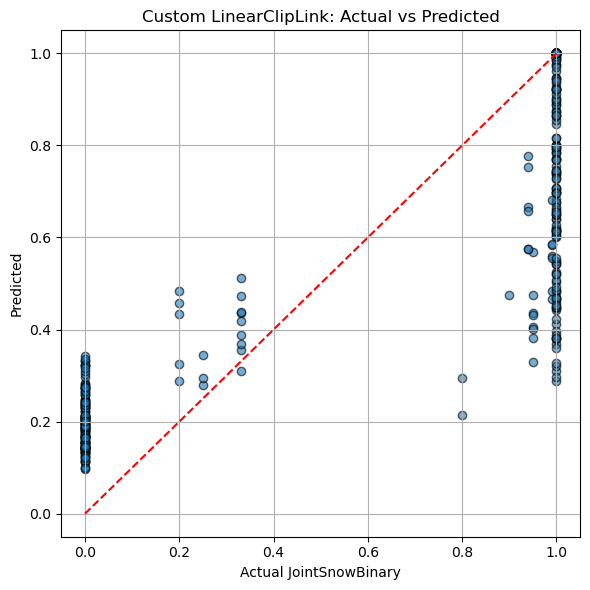

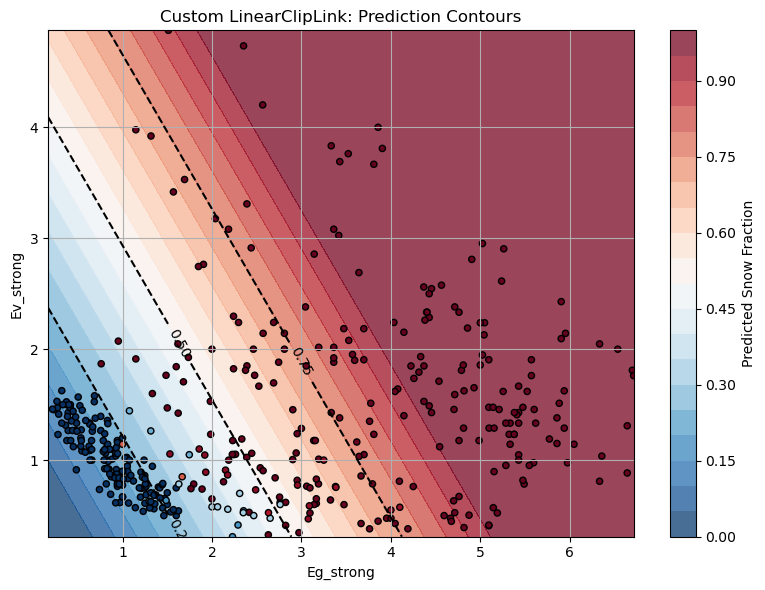

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, confusion_matrix
import statsmodels.api as sm
import statsmodels.genmod.families.links as links
from statsmodels.genmod.families.family import Binomial

# --- Custom Link ---
class LinearClipLink(links.Identity):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps

    def inverse(self, z):
        return np.clip(z, self.eps, 1 - self.eps)

    def __call__(self, p):
        return np.clip(p, self.eps, 1 - self.eps)

    def deriv(self, p):
        return np.ones_like(p)

# --- Bin conversion ---
def fsc_bin(val):
    if val < 0.05:
        return "[0,0.05)"
    elif val < 0.5:
        return "[0.05,0.5)"
    elif val < 0.95:
        return "[0.5,0.95)"
    else:
        return "[0.95,1]"

# --- Preprocessing ---
df = frac_data.dropna(subset=["Eg_strong", "Ev_strong", "JointSnowBinary", "date"]).copy()
extremes = df[(df["JointSnowBinary"] == 0) | (df["JointSnowBinary"] == 1)]
midrange = df[(df["JointSnowBinary"] > 0) & (df["JointSnowBinary"] < 1)]
combined = pd.concat([extremes, midrange])

cameras = combined['date'].unique()
np.random.seed(1)
np.random.shuffle(cameras)
n_test = int(round(len(cameras) * 0.2))
test_cameras = cameras[:n_test]
train_cameras = cameras[n_test:]

train = combined[combined['date'].isin(train_cameras)].copy()
test = combined[combined['date'].isin(test_cameras)].copy()

X_train = train[["Eg_strong", "Ev_strong"]]
y_train = train["JointSnowBinary"]
groups = train["date"]

# --- Cross-validation ---
gkf = GroupKFold(n_splits=4)
rmses = []
rmses_frac = []
biases = []
biases_frac = []
bin_accuracies = []

all_y_val = []
all_y_pred = []
all_Eg_val = []
all_Ev_val = []
all_yval_color = []
all_actual_bins = []
all_pred_bins = []

family = Binomial(link=LinearClipLink())

for train_idx, val_idx in gkf.split(X_train, y_train, groups=groups):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    X_tr_sm = sm.add_constant(X_tr)
    X_val_sm = sm.add_constant(X_val)

    model = sm.GLM(y_tr, X_tr_sm, family=family)
    result = model.fit()
    y_pred = np.clip(result.predict(X_val_sm), 0, 1)

    actual_bins = y_val.apply(fsc_bin)
    pred_bins = pd.Series(y_pred, index=y_val.index).apply(fsc_bin)
    bin_accuracy = (actual_bins == pred_bins).mean()
    bin_accuracies.append(bin_accuracy)

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    bias = np.mean(y_pred - y_val)
    rmses.append(rmse)
    biases.append(bias)

    mask_frac = (y_val > 0) & (y_val < 1)
    if mask_frac.sum() > 0:
        frac_rmse = np.sqrt(mean_squared_error(y_val[mask_frac], y_pred[mask_frac]))
        frac_bias = np.mean(y_pred[mask_frac] - y_val[mask_frac])
        rmses_frac.append(frac_rmse)
        biases_frac.append(frac_bias)

    all_y_val.extend(y_val)
    all_y_pred.extend(y_pred)
    all_Eg_val.extend(X_val["Eg_strong"])
    all_Ev_val.extend(X_val["Ev_strong"])
    all_yval_color.extend(y_val)
    all_actual_bins.extend(actual_bins)
    all_pred_bins.extend(pred_bins)

# --- Fit final model on all training data ---
X_train_sm = sm.add_constant(X_train)
final_model = sm.GLM(y_train, X_train_sm, family=family).fit()

# --- Summary ---
print(f"Cross-Validation RMSE (mean ± std): {np.mean(rmses):.4f} ± {np.std(rmses):.4f}")
print(f"Cross-Validation Bias (mean ± std): {np.mean(biases):.4f} ± {np.std(biases):.4f}")
print(f"Fractional RMSE (mean ± std): {np.mean(rmses_frac):.4f} ± {np.std(rmses_frac):.4f}")
print(f"Fractional Bias (mean ± std): {np.mean(biases_frac):.4f} ± {np.std(biases_frac):.4f}")
print(f"Classification Accuracy (4-bin): {np.mean(bin_accuracies):.2%}")

bin_labels = ["[0,0.05)", "[0.05,0.5)", "[0.5,0.95)", "[0.95,1]"]
conf = confusion_matrix(all_actual_bins, all_pred_bins, labels=bin_labels)
conf_df = pd.DataFrame(conf, index=bin_labels, columns=bin_labels)
print("\nConfusion Matrix (Aggregated across folds):")
print(conf_df)

# --- Plot 1: Actual vs Predicted ---
plt.figure(figsize=(6, 6))
plt.scatter(all_y_val, all_y_pred, alpha=0.6, edgecolor='k')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Actual JointSnowBinary")
plt.ylabel("Predicted")
plt.title("Custom LinearClipLink: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 2: Contour ---
eg_range = np.linspace(df["Eg_strong"].min(), df["Eg_strong"].max(), 300)
ev_range = np.linspace(df["Ev_strong"].min(), df["Ev_strong"].max(), 300)
Eg_grid, Ev_grid = np.meshgrid(eg_range, ev_range)

grid_df = pd.DataFrame({
    "const": 1,
    "Eg_strong": Eg_grid.ravel(),
    "Ev_strong": Ev_grid.ravel()
})
Z = np.clip(final_model.predict(grid_df).values, 0, 1).reshape(Eg_grid.shape)

plt.figure(figsize=(8, 6))
contour = plt.contourf(Eg_grid, Ev_grid, Z, levels=np.linspace(0, 1, 21), cmap='RdBu_r', alpha=0.75)
cbar = plt.colorbar(contour)
cbar.set_label('Predicted Snow Fraction')

lines = plt.contour(Eg_grid, Ev_grid, Z, levels=[0, 0.25, 0.5, 0.75, 1], colors='k', linestyles='--')
plt.clabel(lines, fmt='%1.2f')

plt.scatter(all_Eg_val, all_Ev_val, c=all_yval_color, cmap='RdBu_r', edgecolor='k', s=20)
plt.xlabel("Eg_strong")
plt.ylabel("Ev_strong")
plt.title("Custom LinearClipLink: Prediction Contours")
plt.grid(True)
plt.tight_layout()
plt.show()


Cross-Validation RMSE (mean ± std): 0.1136 ± 0.0693
Cross-Validation Bias (mean ± std): -0.0030 ± 0.0374
Fractional RMSE (mean ± std): 0.2576 ± 0.0798
Fractional Bias (mean ± std): 0.0363 ± 0.1126
Classification Accuracy (4-bin): 87.35%

Confusion Matrix (Aggregated across folds):
            [0,0.05)  [0.05,0.5)  [0.5,0.95)  [0.95,1]
[0,0.05)         139          14           0         0
[0.05,0.5)         1           7           8         1
[0.5,0.95)         1           1           3         6
[0.95,1]           0           7          14       217


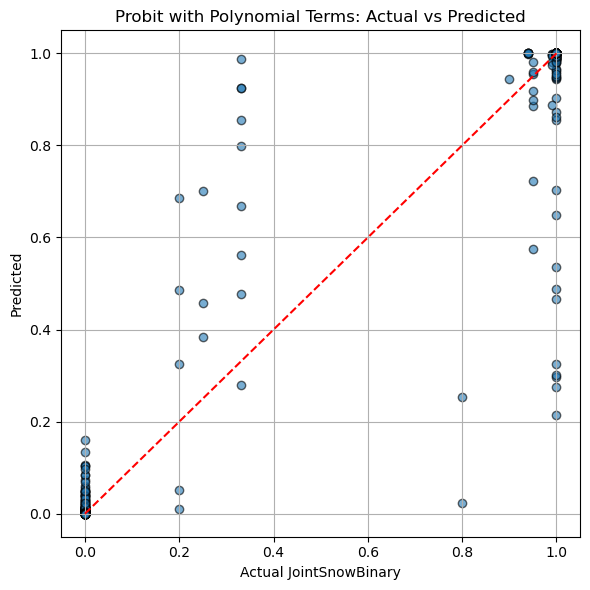

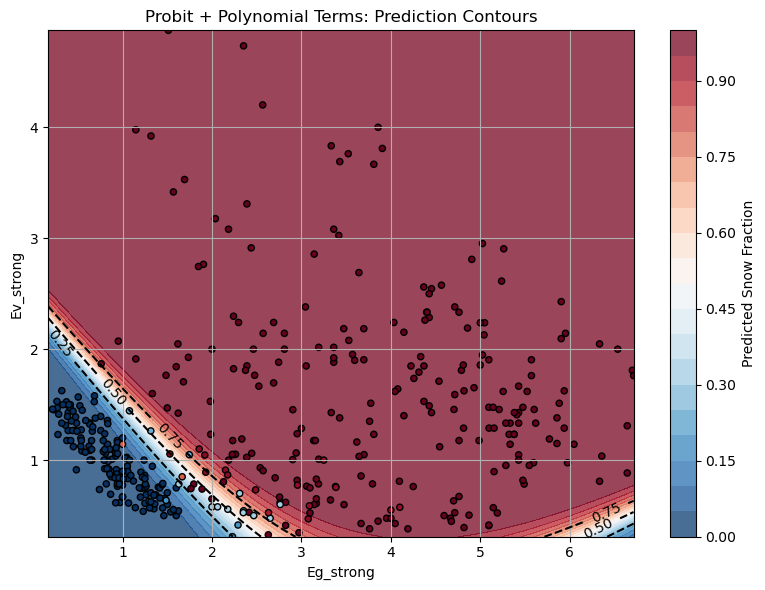

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, confusion_matrix
import statsmodels.api as sm

# --- Binning ---
def fsc_bin(val):
    if val < 0.05:
        return "[0,0.05)"
    elif val < 0.5:
        return "[0.05,0.5)"
    elif val < 0.95:
        return "[0.5,0.95)"
    else:
        return "[0.95,1]"

# --- Preprocessing ---
df = frac_data.dropna(subset=["Eg_strong", "Ev_strong", "JointSnowBinary", "date"]).copy()
extremes = df[(df["JointSnowBinary"] == 0) | (df["JointSnowBinary"] == 1)]
midrange = df[(df["JointSnowBinary"] > 0) & (df["JointSnowBinary"] < 1)]
combined = pd.concat([extremes, midrange])

# Split by camera groups
cameras = combined['date'].unique()
np.random.seed(1)
np.random.shuffle(cameras)
n_test = int(round(len(cameras) * 0.2))
test_cameras = cameras[:n_test]
train_cameras = cameras[n_test:]

train = combined[combined['date'].isin(train_cameras)].copy()
test = combined[combined['date'].isin(test_cameras)].copy()

# Define predictors with polynomial terms
def add_poly_features(df):
    df = df.copy()
    df["Eg2"] = df["Eg_strong"] ** 2
    df["Ev2"] = df["Ev_strong"] ** 2
    df["EgEv"] = df["Eg_strong"] * df["Ev_strong"]
    return df

X_train = add_poly_features(train[["Eg_strong", "Ev_strong"]])
y_train = train["JointSnowBinary"]
groups = train["date"]

# Cross-validation
gkf = GroupKFold(n_splits=4)
rmses = []
rmses_frac = []
biases = []
biases_frac = []
bin_accuracies = []

all_y_val = []
all_y_pred = []
all_Eg_val = []
all_Ev_val = []
all_yval_color = []
all_actual_bins = []
all_pred_bins = []

family = sm.families.Binomial(link=sm.families.links.Probit())

for train_idx, val_idx in gkf.split(X_train, y_train, groups=groups):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    X_tr_sm = sm.add_constant(X_tr)
    X_val_sm = sm.add_constant(X_val)

    model = sm.GLM(y_tr, X_tr_sm, family=family)
    result = model.fit()
    y_pred = np.clip(result.predict(X_val_sm), 0, 1)

    actual_bins = y_val.apply(fsc_bin)
    pred_bins = pd.Series(y_pred, index=y_val.index).apply(fsc_bin)
    bin_accuracy = (actual_bins == pred_bins).mean()
    bin_accuracies.append(bin_accuracy)

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    bias = np.mean(y_pred - y_val)
    rmses.append(rmse)
    biases.append(bias)

    mask_frac = (y_val > 0) & (y_val < 1)
    if mask_frac.sum() > 0:
        frac_rmse = np.sqrt(mean_squared_error(y_val[mask_frac], y_pred[mask_frac]))
        frac_bias = np.mean(y_pred[mask_frac] - y_val[mask_frac])
        rmses_frac.append(frac_rmse)
        biases_frac.append(frac_bias)

    all_y_val.extend(y_val)
    all_y_pred.extend(y_pred)
    all_Eg_val.extend(X_val["Eg_strong"])
    all_Ev_val.extend(X_val["Ev_strong"])
    all_yval_color.extend(y_val)
    all_actual_bins.extend(actual_bins)
    all_pred_bins.extend(pred_bins)

# Fit final model on full training set
X_train_sm = sm.add_constant(X_train)
final_model = sm.GLM(y_train, X_train_sm, family=family).fit()

# --- Summary ---
print(f"Cross-Validation RMSE (mean ± std): {np.mean(rmses):.4f} ± {np.std(rmses):.4f}")
print(f"Cross-Validation Bias (mean ± std): {np.mean(biases):.4f} ± {np.std(biases):.4f}")
print(f"Fractional RMSE (mean ± std): {np.mean(rmses_frac):.4f} ± {np.std(rmses_frac):.4f}")
print(f"Fractional Bias (mean ± std): {np.mean(biases_frac):.4f} ± {np.std(biases_frac):.4f}")
print(f"Classification Accuracy (4-bin): {np.mean(bin_accuracies):.2%}")

bin_labels = ["[0,0.05)", "[0.05,0.5)", "[0.5,0.95)", "[0.95,1]"]
conf = confusion_matrix(all_actual_bins, all_pred_bins, labels=bin_labels)
conf_df = pd.DataFrame(conf, index=bin_labels, columns=bin_labels)
print("\nConfusion Matrix (Aggregated across folds):")
print(conf_df)

# --- Plot 1: Actual vs Predicted ---
plt.figure(figsize=(6, 6))
plt.scatter(all_y_val, all_y_pred, alpha=0.6, edgecolor='k')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Actual JointSnowBinary")
plt.ylabel("Predicted")
plt.title("Probit with Polynomial Terms: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 2: Contour ---
eg_range = np.linspace(df["Eg_strong"].min(), df["Eg_strong"].max(), 300)
ev_range = np.linspace(df["Ev_strong"].min(), df["Ev_strong"].max(), 300)
Eg_grid, Ev_grid = np.meshgrid(eg_range, ev_range)

grid_poly = pd.DataFrame({
    "Eg_strong": Eg_grid.ravel(),
    "Ev_strong": Ev_grid.ravel(),
})
grid_poly = add_poly_features(grid_poly)
grid_poly["const"] = 1  # add intercept term
grid_poly = grid_poly[["const", "Eg_strong", "Ev_strong", "Eg2", "Ev2", "EgEv"]]

Z = np.clip(final_model.predict(grid_poly).values, 0, 1).reshape(Eg_grid.shape)

plt.figure(figsize=(8, 6))
contour = plt.contourf(Eg_grid, Ev_grid, Z, levels=np.linspace(0, 1, 21), cmap='RdBu_r', alpha=0.75)
cbar = plt.colorbar(contour)
cbar.set_label('Predicted Snow Fraction')

lines = plt.contour(Eg_grid, Ev_grid, Z, levels=[0, 0.25, 0.5, 0.75, 1], colors='k', linestyles='--')
plt.clabel(lines, fmt='%1.2f')

plt.scatter(all_Eg_val, all_Ev_val, c=all_yval_color, cmap='RdBu_r', edgecolor='k', s=20)
plt.xlabel("Eg_strong")
plt.ylabel("Ev_strong")
plt.title("Probit + Polynomial Terms: Prediction Contours")
plt.grid(True)
plt.tight_layout()
plt.show()


Cross-Validation RMSE (mean ± std): 0.1175 ± 0.0764
Cross-Validation Bias (mean ± std): -0.0048 ± 0.0380
Fractional RMSE (mean ± std): 0.2672 ± 0.1042
Fractional Bias (mean ± std): 0.0206 ± 0.1071
Classification Accuracy (4-bin): 87.34%

Confusion Matrix (Aggregated across folds):
            [0,0.05)  [0.05,0.5)  [0.5,0.95)  [0.95,1]
[0,0.05)         146           7           0         0
[0.05,0.5)         3           3           9         2
[0.5,0.95)         1           1           2         7
[0.95,1]           1           6          16       215


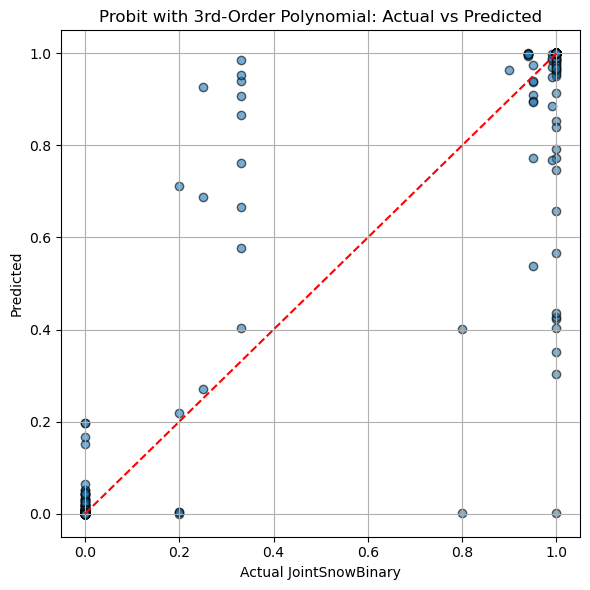

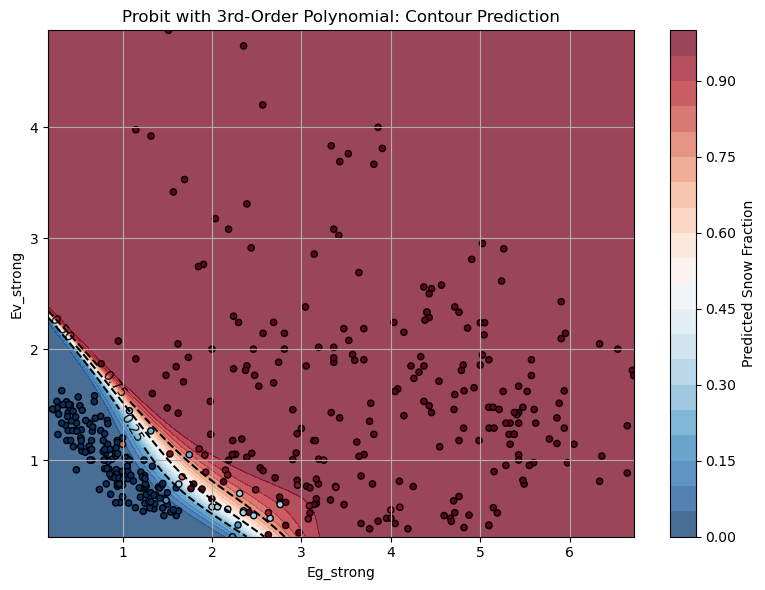

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, confusion_matrix
import statsmodels.api as sm

def fsc_bin(val):
    if val < 0.05:
        return "[0,0.05)"
    elif val < 0.5:
        return "[0.05,0.5)"
    elif val < 0.95:
        return "[0.5,0.95)"
    else:
        return "[0.95,1]"

# --- Preprocessing ---
df = frac_data.dropna(subset=["Eg_strong", "Ev_strong", "JointSnowBinary", "date"]).copy()
extremes = df[(df["JointSnowBinary"] == 0) | (df["JointSnowBinary"] == 1)]
midrange = df[(df["JointSnowBinary"] > 0) & (df["JointSnowBinary"] < 1)]
combined = pd.concat([extremes, midrange])

# Camera-based group split
cameras = combined['date'].unique()
np.random.seed(1)
np.random.shuffle(cameras)
n_test = int(round(len(cameras) * 0.2))
test_cameras = cameras[:n_test]
train_cameras = cameras[n_test:]

train = combined[combined['date'].isin(train_cameras)].copy()
test = combined[combined['date'].isin(test_cameras)].copy()

# --- Polynomial Feature Expansion ---
def add_poly3_features(df):
    df = df.copy()
    df["Eg2"] = df["Eg_strong"] ** 2
    df["Ev2"] = df["Ev_strong"] ** 2
    df["EgEv"] = df["Eg_strong"] * df["Ev_strong"]
    df["Eg3"] = df["Eg_strong"] ** 3
    df["Ev3"] = df["Ev_strong"] ** 3
    df["Eg2Ev"] = df["Eg2"] * df["Ev_strong"]
    df["EgEv2"] = df["Eg_strong"] * df["Ev2"]
    return df

X_train = add_poly3_features(train[["Eg_strong", "Ev_strong"]])
y_train = train["JointSnowBinary"]
groups = train["date"]

# --- Cross-validation ---
gkf = GroupKFold(n_splits=4)
rmses = []
rmses_frac = []
biases = []
biases_frac = []
bin_accuracies = []

all_y_val = []
all_y_pred = []
all_Eg_val = []
all_Ev_val = []
all_yval_color = []
all_actual_bins = []
all_pred_bins = []

family = sm.families.Binomial(link=sm.families.links.Probit())

for train_idx, val_idx in gkf.split(X_train, y_train, groups=groups):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    X_tr_sm = sm.add_constant(X_tr)
    X_val_sm = sm.add_constant(X_val)

    model = sm.GLM(y_tr, X_tr_sm, family=family)
    result = model.fit()
    y_pred = np.clip(result.predict(X_val_sm), 0, 1)

    actual_bins = y_val.apply(fsc_bin)
    pred_bins = pd.Series(y_pred, index=y_val.index).apply(fsc_bin)
    bin_accuracy = (actual_bins == pred_bins).mean()
    bin_accuracies.append(bin_accuracy)

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    bias = np.mean(y_pred - y_val)
    rmses.append(rmse)
    biases.append(bias)

    mask_frac = (y_val > 0) & (y_val < 1)
    if mask_frac.sum() > 0:
        frac_rmse = np.sqrt(mean_squared_error(y_val[mask_frac], y_pred[mask_frac]))
        frac_bias = np.mean(y_pred[mask_frac] - y_val[mask_frac])
        rmses_frac.append(frac_rmse)
        biases_frac.append(frac_bias)

    all_y_val.extend(y_val)
    all_y_pred.extend(y_pred)
    all_Eg_val.extend(X_val["Eg_strong"])
    all_Ev_val.extend(X_val["Ev_strong"])
    all_yval_color.extend(y_val)
    all_actual_bins.extend(actual_bins)
    all_pred_bins.extend(pred_bins)

# --- Fit final model on full training set ---
X_train_sm = sm.add_constant(X_train)
final_model = sm.GLM(y_train, X_train_sm, family=family).fit()

# --- Summary ---
print(f"Cross-Validation RMSE (mean ± std): {np.mean(rmses):.4f} ± {np.std(rmses):.4f}")
print(f"Cross-Validation Bias (mean ± std): {np.mean(biases):.4f} ± {np.std(biases):.4f}")
print(f"Fractional RMSE (mean ± std): {np.mean(rmses_frac):.4f} ± {np.std(rmses_frac):.4f}")
print(f"Fractional Bias (mean ± std): {np.mean(biases_frac):.4f} ± {np.std(biases_frac):.4f}")
print(f"Classification Accuracy (4-bin): {np.mean(bin_accuracies):.2%}")

bin_labels = ["[0,0.05)", "[0.05,0.5)", "[0.5,0.95)", "[0.95,1]"]
conf = confusion_matrix(all_actual_bins, all_pred_bins, labels=bin_labels)
conf_df = pd.DataFrame(conf, index=bin_labels, columns=bin_labels)
print("\nConfusion Matrix (Aggregated across folds):")
print(conf_df)

# --- Plot 1: Actual vs Predicted ---
plt.figure(figsize=(6, 6))
plt.scatter(all_y_val, all_y_pred, alpha=0.6, edgecolor='k')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Actual JointSnowBinary")
plt.ylabel("Predicted")
plt.title("Probit with 3rd-Order Polynomial: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 2: Contour Plot ---
eg_range = np.linspace(df["Eg_strong"].min(), df["Eg_strong"].max(), 300)
ev_range = np.linspace(df["Ev_strong"].min(), df["Ev_strong"].max(), 300)
Eg_grid, Ev_grid = np.meshgrid(eg_range, ev_range)

grid_df = pd.DataFrame({
    "Eg_strong": Eg_grid.ravel(),
    "Ev_strong": Ev_grid.ravel(),
})
grid_df = add_poly3_features(grid_df)
grid_df["const"] = 1
grid_df = grid_df[["const", "Eg_strong", "Ev_strong", "Eg2", "Ev2", "EgEv", "Eg3", "Ev3", "Eg2Ev", "EgEv2"]]

Z = np.clip(final_model.predict(grid_df).values, 0, 1).reshape(Eg_grid.shape)

plt.figure(figsize=(8, 6))
contour = plt.contourf(Eg_grid, Ev_grid, Z, levels=np.linspace(0, 1, 21), cmap='RdBu_r', alpha=0.75)
cbar = plt.colorbar(contour)
cbar.set_label('Predicted Snow Fraction')

lines = plt.contour(Eg_grid, Ev_grid, Z, levels=[0, 0.25, 0.5, 0.75, 1], colors='k', linestyles='--')
plt.clabel(lines, fmt='%1.2f')

plt.scatter(all_Eg_val, all_Ev_val, c=all_yval_color, cmap='RdBu_r', edgecolor='k', s=20)
plt.xlabel("Eg_strong")
plt.ylabel("Ev_strong")
plt.title("Probit with 3rd-Order Polynomial: Contour Prediction")
plt.grid(True)
plt.tight_layout()
plt.show()



Grid Search Summary:
                name      rmse  rmse_frac      bias  bias_frac  bin_accuracy
1    Binomial-Probit  0.118266   0.266189 -0.002380  -0.003115      0.849588
0     Binomial-Logit  0.118653   0.268379 -0.000011   0.017134      0.866277
2   Binomial-CLogLog  0.135576   0.268722 -0.000266  -0.087406      0.690064
3  Gaussian-Identity  0.258620   0.355610 -0.040593  -0.197265      0.305540
4       Gaussian-Log  0.324162   0.370446 -0.003853  -0.174672      0.250687

Best GLM model: Binomial-Probit

Confusion Matrix (Best model):
            [0,0.05)  [0.05,0.5)  [0.5,0.95)  [0.95,1]
[0,0.05)         133          20           0         0
[0.05,0.5)         2           6           7         2
[0.5,0.95)         1           1           2         7
[0.95,1]           0           7          16       215


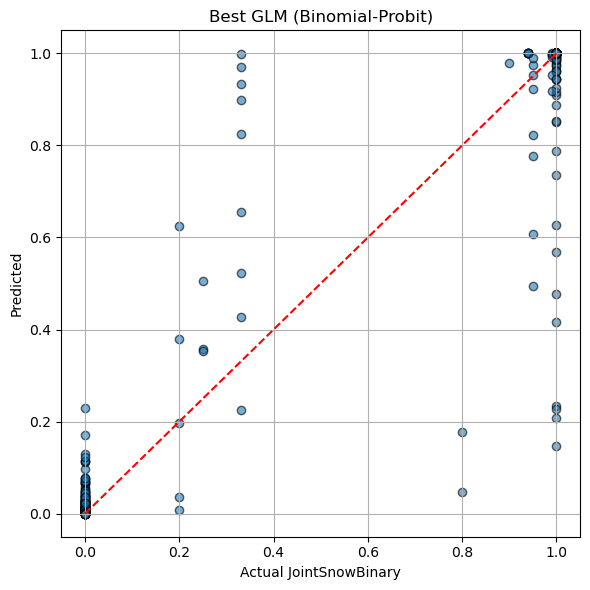

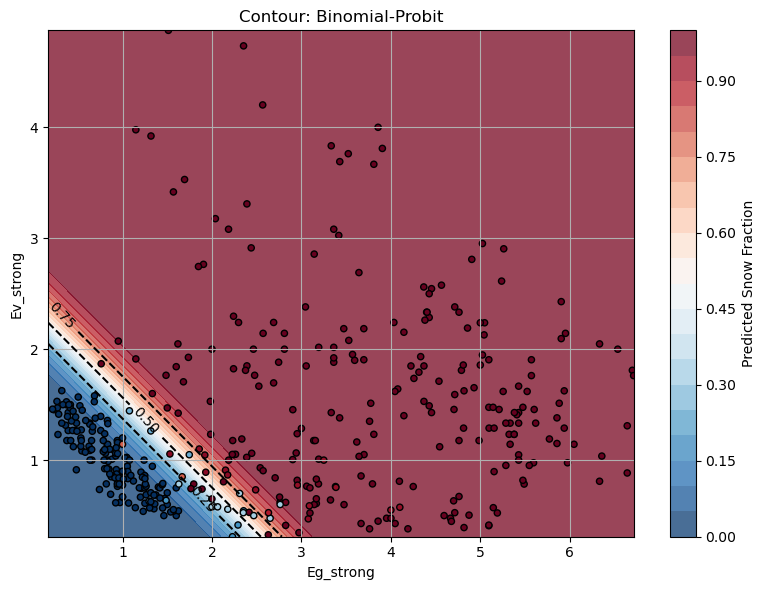

In [75]:
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, confusion_matrix
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def fsc_bin(val):
    if val < 0.05:
        return "[0,0.05)"
    elif val < 0.5:
        return "[0.05,0.5)"
    elif val < 0.95:
        return "[0.5,0.95)"
    else:
        return "[0.95,1]"

# --- Preprocessing ---
df = frac_data.dropna(subset=["Eg_strong", "Ev_strong", "JointSnowBinary", "date"]).copy()
extremes = df[(df["JointSnowBinary"] == 0) | (df["JointSnowBinary"] == 1)]
midrange = df[(df["JointSnowBinary"] > 0) & (df["JointSnowBinary"] < 1)]
combined = pd.concat([extremes, midrange])

# Group cameras into train/test
cameras = combined['date'].unique()
np.random.seed(1)
np.random.shuffle(cameras)
n_test = int(round(len(cameras) * 0.2))
test_cameras = cameras[:n_test]
train_cameras = cameras[n_test:]

train = combined[combined['date'].isin(train_cameras)].copy()
test = combined[combined['date'].isin(test_cameras)].copy()

X_train = train[["Eg_strong", "Ev_strong"]]
y_train = train["JointSnowBinary"]
groups = train["date"]

# --- Grid of families and links ---
grid = [
    (sm.families.Binomial(link=sm.families.links.Logit()), "Binomial-Logit"),
    (sm.families.Binomial(link=sm.families.links.Probit()), "Binomial-Probit"),
    (sm.families.Binomial(link=sm.families.links.CLogLog()), "Binomial-CLogLog"),
    (sm.families.Gaussian(link=sm.families.links.Identity()), "Gaussian-Identity"),
    (sm.families.Gaussian(link=sm.families.links.Log()), "Gaussian-Log"),
]

gkf = GroupKFold(n_splits=4)
results = []
best_rmse = np.inf

for family, name in grid:
    rmses = []
    rmses_frac = []
    biases = []
    biases_frac = []
    bin_accuracies = []

    all_y_val = []
    all_y_pred = []
    all_Eg_val = []
    all_Ev_val = []
    all_yval_color = []
    all_actual_bins = []
    all_pred_bins = []

    for train_idx, val_idx in gkf.split(X_train, y_train, groups=groups):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        X_tr_sm = sm.add_constant(X_tr)
        X_val_sm = sm.add_constant(X_val)

        try:
            model = sm.GLM(y_tr, X_tr_sm, family=family)
            result = model.fit()
            y_pred = np.clip(result.predict(X_val_sm), 0, 1)
        except:
            continue  # Skip models that fail (e.g., log of 0)

        actual_bins = y_val.apply(fsc_bin)
        pred_bins = pd.Series(y_pred, index=y_val.index).apply(fsc_bin)

        bin_accuracy = (actual_bins == pred_bins).mean()
        bin_accuracies.append(bin_accuracy)

        all_actual_bins.extend(actual_bins)
        all_pred_bins.extend(pred_bins)

        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        bias = np.mean(y_pred - y_val)
        rmses.append(rmse)
        biases.append(bias)

        mask_frac = (y_val > 0) & (y_val < 1)
        if mask_frac.sum() > 0:
            frac_rmse = np.sqrt(mean_squared_error(y_val[mask_frac], y_pred[mask_frac]))
            frac_bias = np.mean(y_pred[mask_frac] - y_val[mask_frac])
            rmses_frac.append(frac_rmse)
            biases_frac.append(frac_bias)

        all_y_val.extend(y_val)
        all_y_pred.extend(y_pred)
        all_Eg_val.extend(X_val["Eg_strong"])
        all_Ev_val.extend(X_val["Ev_strong"])
        all_yval_color.extend(y_val)

    mean_rmse = np.mean(rmses)
    if mean_rmse < best_rmse:
        best_rmse = mean_rmse
        best_model_name = name
        best_family = family
        best_y_val = all_y_val
        best_y_pred = all_y_pred
        best_Eg_val = all_Eg_val
        best_Ev_val = all_Ev_val
        best_yval_color = all_yval_color
        best_actual_bins = all_actual_bins
        best_pred_bins = all_pred_bins

    results.append({
        "name": name,
        "rmse": mean_rmse,
        "rmse_std": np.std(rmses),
        "rmse_frac": np.mean(rmses_frac) if rmses_frac else np.nan,
        "bias": np.mean(biases),
        "bias_frac": np.mean(biases_frac) if biases_frac else np.nan,
        "bin_accuracy": np.mean(bin_accuracies)
    })

# --- Fit final model on all training data ---
X_train_sm = sm.add_constant(X_train)
final_model = sm.GLM(y_train, X_train_sm, family=best_family).fit()

# --- Summary ---
print("\nGrid Search Summary:")
df_results = pd.DataFrame(results).sort_values("rmse")
print(df_results[["name", "rmse", "rmse_frac", "bias", "bias_frac", "bin_accuracy"]])

print(f"\nBest GLM model: {best_model_name}")

bin_labels = ["[0,0.05)", "[0.05,0.5)", "[0.5,0.95)", "[0.95,1]"]
conf = confusion_matrix(best_actual_bins, best_pred_bins, labels=bin_labels)
conf_df = pd.DataFrame(conf, index=bin_labels, columns=bin_labels)
print("\nConfusion Matrix (Best model):")
print(conf_df)

# --- Plot 1: Scatter ---
plt.figure(figsize=(6, 6))
plt.scatter(best_y_val, best_y_pred, alpha=0.6, edgecolor='k')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Actual JointSnowBinary")
plt.ylabel("Predicted")
plt.title(f"Best GLM ({best_model_name})")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 2: Contour ---
eg_range = np.linspace(df["Eg_strong"].min(), df["Eg_strong"].max(), 300)
ev_range = np.linspace(df["Ev_strong"].min(), df["Ev_strong"].max(), 300)
Eg_grid, Ev_grid = np.meshgrid(eg_range, ev_range)

grid_df = pd.DataFrame({
    "const": 1,
    "Eg_strong": Eg_grid.ravel(),
    "Ev_strong": Ev_grid.ravel()
})
Z = np.clip(final_model.predict(grid_df).values, 0, 1).reshape(Eg_grid.shape)

plt.figure(figsize=(8, 6))
contour = plt.contourf(Eg_grid, Ev_grid, Z, levels=np.linspace(0, 1, 21), cmap='RdBu_r', alpha=0.75)
cbar = plt.colorbar(contour)
cbar.set_label('Predicted Snow Fraction')

lines = plt.contour(Eg_grid, Ev_grid, Z, levels=[0, 0.25, 0.5, 0.75, 1], colors='k', linestyles='--')
plt.clabel(lines, fmt='%1.2f')

plt.scatter(best_Eg_val, best_Ev_val, c=best_yval_color, cmap='RdBu_r', edgecolor='k', s=20)
plt.xlabel("Eg_strong")
plt.ylabel("Ev_strong")
plt.title(f"Contour: {best_model_name}")
plt.grid(True)
plt.tight_layout()
plt.show()



Top SVR Hyperparameter Combinations (by mean RMSE):
C=10, epsilon=0.05, gamma=auto, RMSE=0.1239 ± 0.0532, Fractional RMSE=0.2694 ± 0.0602, Bin Acc=77.56%
C=100, epsilon=0.01, gamma=auto, RMSE=0.1257 ± 0.0492, Fractional RMSE=0.2824 ± 0.0663, Bin Acc=82.34%
C=100, epsilon=0.05, gamma=scale, RMSE=0.1263 ± 0.0479, Fractional RMSE=0.2685 ± 0.0550, Bin Acc=74.71%

Best parameters used for plotting: C=10, epsilon=0.05, gamma=auto


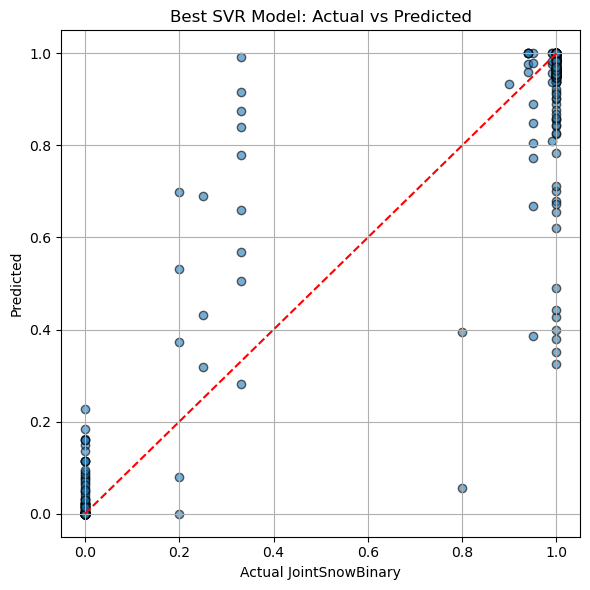

/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


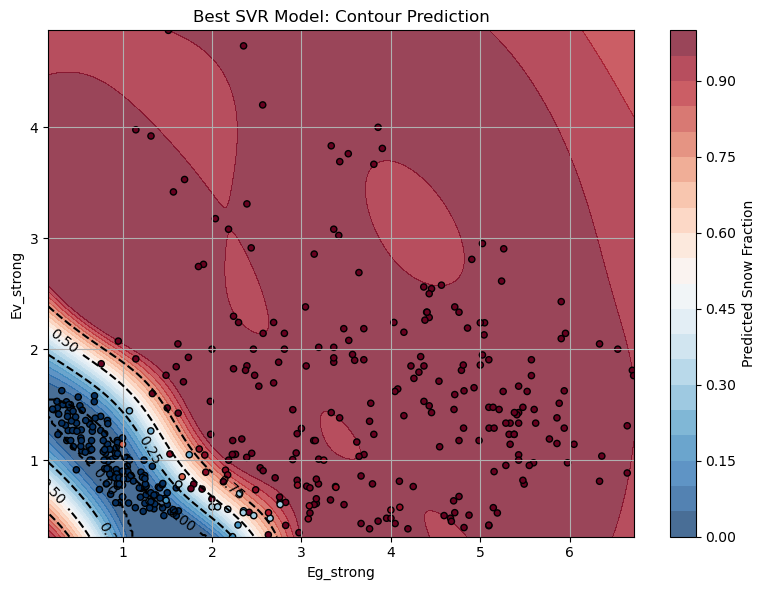


Confusion Matrix (Best Model):
            [0,0.05)  [0.05,0.5)  [0.5,0.95)  [0.95,1]
[0,0.05)         131          22           0         0
[0.05,0.5)         1           5          10         1
[0.5,0.95)         0           2           3         6
[0.95,1]           0           8          44       186


In [78]:
from sklearn.svm import SVR
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from itertools import product

def fsc_bin(val):
    if val < 0.05:
        return "[0,0.05)"
    elif val < 0.5:
        return "[0.05,0.5)"
    elif val < 0.95:
        return "[0.5,0.95)"
    else:
        return "[0.95,1]"

# Preprocessing
df = frac_data.dropna(subset=["Eg_strong", "Ev_strong", "JointSnowBinary", "date"]).copy()
extremes = df[(df["JointSnowBinary"] == 0) | (df["JointSnowBinary"] == 1)]
midrange = df[(df["JointSnowBinary"] > 0) & (df["JointSnowBinary"] < 1)]
combined = pd.concat([extremes, midrange])

cameras = combined['date'].unique()
np.random.seed(1)
np.random.shuffle(cameras)
n_test = int(round(len(cameras) * 0.2))
test_cameras = cameras[:n_test]
train_cameras = cameras[n_test:]

train = combined[combined['date'].isin(train_cameras)].copy()
test = combined[combined['date'].isin(test_cameras)].copy()

X_train = train[["Eg_strong", "Ev_strong"]]
y_train = train["JointSnowBinary"]
groups = train["date"]

# Grid setup
param_grid = {
    "C": [1, 10, 100],
    "epsilon": [0.01, 0.05, 0.1],
    "gamma": ["scale", "auto"],
}
param_combinations = list(product(param_grid["C"], param_grid["epsilon"], param_grid["gamma"]))

gkf = GroupKFold(n_splits=4)
results = []
best_model = None
best_rmse = np.inf

for C, epsilon, gamma in param_combinations:
    rmses = []
    rmses_frac = []
    bin_accuracies = []

    all_y_val = []
    all_y_pred = []
    all_Eg_val = []
    all_Ev_val = []
    all_yval_color = []
    all_actual_bins = []
    all_pred_bins = []

    for train_idx, val_idx in gkf.split(X_train, y_train, groups=groups):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = SVR(kernel="rbf", C=C, epsilon=epsilon, gamma=gamma)
        model.fit(X_tr, y_tr)
        y_pred = np.clip(model.predict(X_val), 0, 1)

        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmses.append(rmse)

        mask_frac = (y_val > 0) & (y_val < 1)
        if mask_frac.sum() > 0:
            rmse_frac = np.sqrt(mean_squared_error(y_val[mask_frac], y_pred[mask_frac]))
            rmses_frac.append(rmse_frac)

        actual_bins = y_val.apply(fsc_bin)
        pred_bins = pd.Series(y_pred, index=y_val.index).apply(fsc_bin)
        bin_accuracy = (actual_bins == pred_bins).mean()
        bin_accuracies.append(bin_accuracy)

        all_y_val.extend(y_val)
        all_y_pred.extend(y_pred)
        all_Eg_val.extend(X_val["Eg_strong"])
        all_Ev_val.extend(X_val["Ev_strong"])
        all_yval_color.extend(y_val)
        all_actual_bins.extend(actual_bins)
        all_pred_bins.extend(pred_bins)

    mean_rmse = np.mean(rmses)
    std_rmse = np.std(rmses)
    mean_frac_rmse = np.mean(rmses_frac) if rmses_frac else np.nan
    std_frac_rmse = np.std(rmses_frac) if rmses_frac else np.nan
    mean_bin_acc = np.mean(bin_accuracies)

    results.append({
        "C": C,
        "epsilon": epsilon,
        "gamma": gamma,
        "mean_rmse": mean_rmse,
        "std_rmse": std_rmse,
        "mean_frac_rmse": mean_frac_rmse,
        "std_frac_rmse": std_frac_rmse,
        "bin_accuracy": mean_bin_acc
    })

    if mean_rmse < best_rmse:
        best_rmse = mean_rmse
        best_model = SVR(kernel="rbf", C=C, epsilon=epsilon, gamma=gamma)
        best_model.fit(X_train, y_train)
        best_y_val = all_y_val
        best_y_pred = all_y_pred
        best_Eg_val = all_Eg_val
        best_Ev_val = all_Ev_val
        best_yval_color = all_yval_color
        best_actual_bins = all_actual_bins
        best_pred_bins = all_pred_bins
        best_params = (C, epsilon, gamma)

# Sort and display top 3
results = sorted(results, key=lambda x: x["mean_rmse"])
print("\nTop SVR Hyperparameter Combinations (by mean RMSE):")
for r in results[:3]:
    print(f"C={r['C']}, epsilon={r['epsilon']}, gamma={r['gamma']}, "
          f"RMSE={r['mean_rmse']:.4f} ± {r['std_rmse']:.4f}, "
          f"Fractional RMSE={r['mean_frac_rmse']:.4f} ± {r['std_frac_rmse']:.4f}, "
          f"Bin Acc={r['bin_accuracy']:.2%}")

print(f"\nBest parameters used for plotting: C={best_params[0]}, epsilon={best_params[1]}, gamma={best_params[2]}")

# === PLOTS ===

# 1. Scatter: Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(best_y_val, best_y_pred, alpha=0.6, edgecolor='k')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Actual JointSnowBinary")
plt.ylabel("Predicted")
plt.title("Best SVR Model: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Contour: Prediction surface
eg_range = np.linspace(df["Eg_strong"].min(), df["Eg_strong"].max(), 300)
ev_range = np.linspace(df["Ev_strong"].min(), df["Ev_strong"].max(), 300)
Eg_grid, Ev_grid = np.meshgrid(eg_range, ev_range)
grid_points = np.column_stack([Eg_grid.ravel(), Ev_grid.ravel()])
Z = np.clip(best_model.predict(grid_points), 0, 1).reshape(Eg_grid.shape)

plt.figure(figsize=(8, 6))
contour = plt.contourf(Eg_grid, Ev_grid, Z, levels=np.linspace(0, 1, 21), cmap='RdBu_r', alpha=0.75)
cbar = plt.colorbar(contour)
cbar.set_label('Predicted Snow Fraction')

lines = plt.contour(Eg_grid, Ev_grid, Z, levels=[0, 0.25, 0.5, 0.75, 1], colors='k', linestyles='--')
plt.clabel(lines, fmt='%1.2f')

plt.scatter(best_Eg_val, best_Ev_val, c=best_yval_color, cmap='RdBu_r', edgecolor='k', s=20)
plt.xlabel("Eg_strong")
plt.ylabel("Ev_strong")
plt.title("Best SVR Model: Contour Prediction")
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Confusion Matrix
from sklearn.metrics import confusion_matrix

bin_labels = ["[0,0.05)", "[0.05,0.5)", "[0.5,0.95)", "[0.95,1]"]
conf = confusion_matrix(best_actual_bins, best_pred_bins, labels=bin_labels)
conf_df = pd.DataFrame(conf, index=bin_labels, columns=bin_labels)

print("\nConfusion Matrix (Best Model):")
print(conf_df)


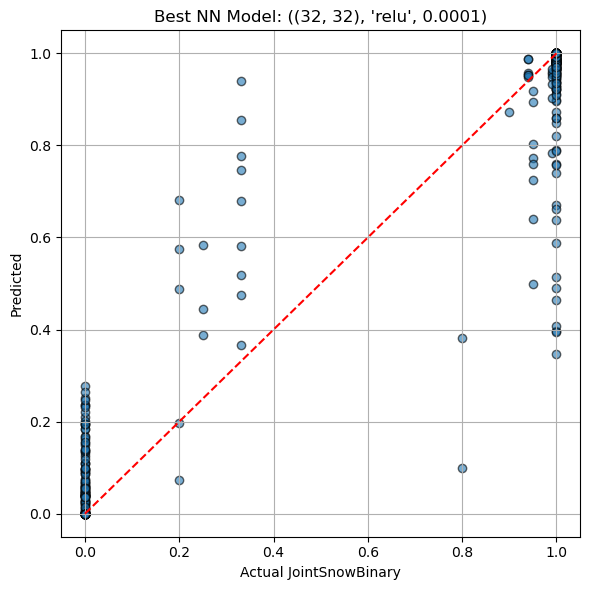

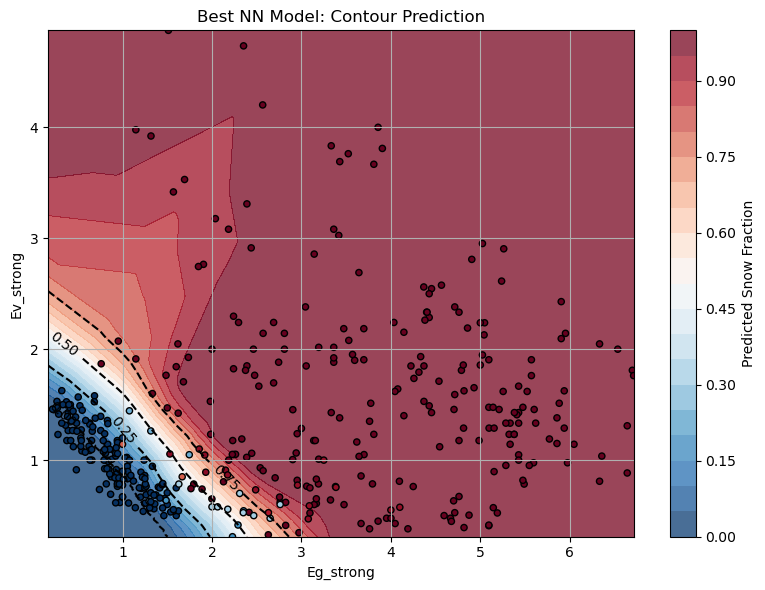


Best Params: hidden_layer_sizes=(32, 32), activation=relu, alpha=0.0001
Cross-Validation RMSE: 0.1284

Confusion Matrix (Aggregated across folds):
            [0,0.05)  [0.05,0.5)  [0.5,0.95)  [0.95,1]
[0,0.05)          96          57           0         0
[0.05,0.5)         0           7          10         0
[0.5,0.95)         0           2           4         5
[0.95,1]           0           7          44       187


In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix
from itertools import product

def fsc_bin(val):
    if val < 0.05:
        return "[0,0.05)"
    elif val < 0.5:
        return "[0.05,0.5)"
    elif val < 0.95:
        return "[0.5,0.95)"
    else:
        return "[0.95,1]"

# Drop missing
df = frac_data.dropna(subset=["Eg_strong", "Ev_strong", "JointSnowBinary", "date"]).copy()
extremes = df[(df["JointSnowBinary"] == 0) | (df["JointSnowBinary"] == 1)]
midrange = df[(df["JointSnowBinary"] > 0) & (df["JointSnowBinary"] < 1)]
combined = pd.concat([extremes, midrange])

cameras = combined['date'].unique()
np.random.seed(1)
np.random.shuffle(cameras)
n_test = int(round(len(cameras) * 0.2))
test_cameras = cameras[:n_test]
train_cameras = cameras[n_test:]

train = combined[combined['date'].isin(train_cameras)].copy()
test = combined[combined['date'].isin(test_cameras)].copy()

X_train = train[["Eg_strong", "Ev_strong"]]
y_train = train["JointSnowBinary"]
groups = train["date"]

# Define parameter grid
param_grid = list(product(
    [(16,), (32,), (32, 32)],
    ['relu', 'tanh'],
    [1e-4, 1e-3]
))

gkf = GroupKFold(n_splits=4, shuffle=False)
results = []
best_model = None
best_rmse = np.inf

for hidden_layer_sizes, activation, alpha in param_grid:
    rmses = []
    rmses_fractional = []
    biases = []
    biases_fractional = []
    bin_accuracies = []

    all_y_val = []
    all_y_pred = []
    all_Eg_val = []
    all_Ev_val = []
    all_yval_color = []
    all_actual_bins = []
    all_pred_bins = []

    for train_idx, val_idx in gkf.split(X_train, y_train, groups=groups):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = MLPRegressor(
            hidden_layer_sizes=hidden_layer_sizes,
            activation=activation,
            solver='adam',
            alpha=alpha,
            max_iter=1000,
            random_state=42
        )
        model.fit(X_tr, y_tr)
        y_pred = np.clip(model.predict(X_val), 0, 1)

        actual_bins = y_val.apply(fsc_bin)
        pred_bins = pd.Series(y_pred, index=y_val.index).apply(fsc_bin)
        bin_accuracy = (actual_bins == pred_bins).mean()
        bin_accuracies.append(bin_accuracy)

        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        bias = np.mean(y_pred - y_val)
        rmses.append(rmse)
        biases.append(bias)

        mask_frac = (y_val > 0) & (y_val < 1)
        if mask_frac.sum() > 0:
            frac_rmse = np.sqrt(mean_squared_error(y_val[mask_frac], y_pred[mask_frac]))
            frac_bias = np.mean(y_pred[mask_frac] - y_val[mask_frac])
            rmses_fractional.append(frac_rmse)
            biases_fractional.append(frac_bias)

        all_y_val.extend(y_val)
        all_y_pred.extend(y_pred)
        all_Eg_val.extend(X_val["Eg_strong"])
        all_Ev_val.extend(X_val["Ev_strong"])
        all_yval_color.extend(y_val)
        all_actual_bins.extend(actual_bins)
        all_pred_bins.extend(pred_bins)

    mean_rmse = np.mean(rmses)

    results.append({
        "hidden_layer_sizes": hidden_layer_sizes,
        "activation": activation,
        "alpha": alpha,
        "rmse": mean_rmse,
        "rmse_frac": np.mean(rmses_fractional) if rmses_fractional else np.nan,
        "bias": np.mean(biases),
        "bias_frac": np.mean(biases_fractional) if biases_fractional else np.nan,
        "bin_accuracy": np.mean(bin_accuracies)
    })

    if mean_rmse < best_rmse:
        best_rmse = mean_rmse
        best_model = MLPRegressor(
            hidden_layer_sizes=hidden_layer_sizes,
            activation=activation,
            solver='adam',
            alpha=alpha,
            max_iter=1000,
            random_state=42
        )
        best_model.fit(X_train, y_train)
        best_y_val = all_y_val
        best_y_pred = all_y_pred
        best_Eg_val = all_Eg_val
        best_Ev_val = all_Ev_val
        best_yval_color = all_yval_color
        best_actual_bins = all_actual_bins
        best_pred_bins = all_pred_bins
        best_params = (hidden_layer_sizes, activation, alpha)

# === Final Fit and Plotting ===

# Plot 1: Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(best_y_val, best_y_pred, alpha=0.6, edgecolor='k')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Actual JointSnowBinary")
plt.ylabel("Predicted")
plt.title(f"Best NN Model: {best_params}")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Contour using best model
eg_range = np.linspace(df["Eg_strong"].min(), df["Eg_strong"].max(), 300)
ev_range = np.linspace(df["Ev_strong"].min(), df["Ev_strong"].max(), 300)
Eg_grid, Ev_grid = np.meshgrid(eg_range, ev_range)

grid_points = pd.DataFrame({
    "Eg_strong": Eg_grid.ravel(),
    "Ev_strong": Ev_grid.ravel()
})
Z = np.clip(best_model.predict(grid_points), 0, 1).reshape(Eg_grid.shape)

plt.figure(figsize=(8, 6))
contour = plt.contourf(Eg_grid, Ev_grid, Z, levels=np.linspace(0, 1, 21), cmap='RdBu_r', alpha=0.75)
cbar = plt.colorbar(contour)
cbar.set_label('Predicted Snow Fraction')

lines = plt.contour(Eg_grid, Ev_grid, Z, levels=[0, 0.25, 0.5, 0.75, 1], colors='k', linestyles='--')
plt.clabel(lines, fmt='%1.2f')
plt.scatter(best_Eg_val, best_Ev_val, c=best_yval_color, cmap='RdBu_r', edgecolor='k', s=20)
plt.xlabel("Eg_strong")
plt.ylabel("Ev_strong")
plt.title("Best NN Model: Contour Prediction")
plt.grid(True)
plt.tight_layout()
plt.show()

# Summary
print(f"\nBest Params: hidden_layer_sizes={best_params[0]}, activation={best_params[1]}, alpha={best_params[2]}")
print(f"Cross-Validation RMSE: {best_rmse:.4f}")

bin_labels = ["[0,0.05)", "[0.05,0.5)", "[0.5,0.95)", "[0.95,1]"]
conf = confusion_matrix(best_actual_bins, best_pred_bins, labels=bin_labels)
conf_df = pd.DataFrame(conf, index=bin_labels, columns=bin_labels)

print("\nConfusion Matrix (Aggregated across folds):")
print(conf_df)


### Train on fraction, result on all data

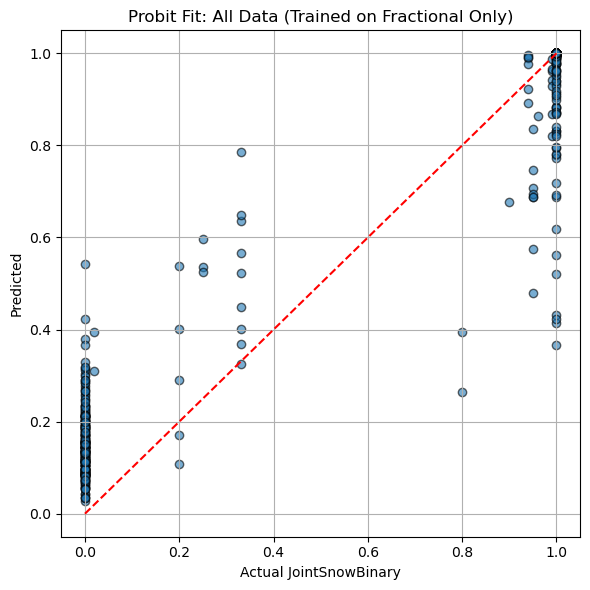

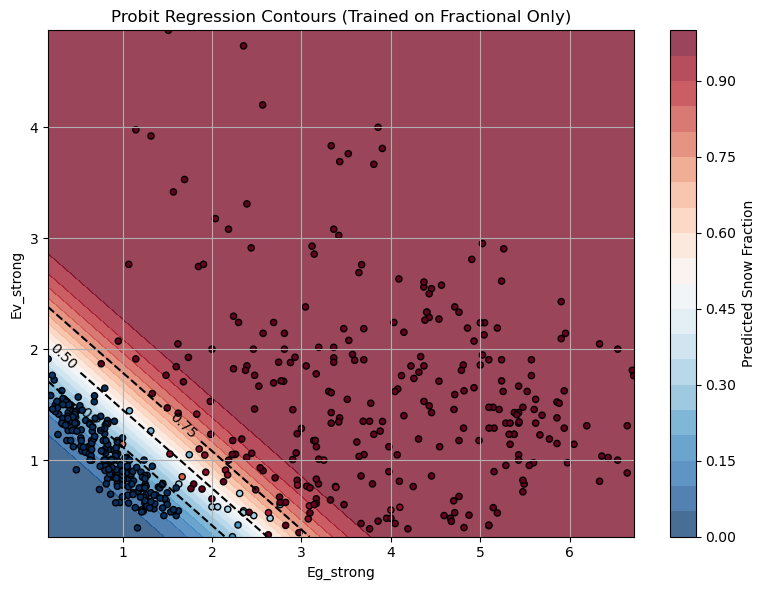

Overall RMSE: 0.1483
Overall Bias: 0.0465
Fractional RMSE: 0.2355
Fractional Bias: 0.0009
Classification Accuracy (4-bin): 47.89%

Confusion Matrix:
            [0,0.05)  [0.05,0.5)  [0.5,0.95)  [0.95,1]
[0,0.05)           6         208           1         0
[0.05,0.5)         0           8           9         0
[0.5,0.95)         0           2           5         4
[0.95,1]           0           5          43       231


In [4]:
from sklearn.metrics import mean_squared_error, confusion_matrix
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def fsc_bin(val):
    if val < 0.05:
        return "[0,0.05)"
    elif val < 0.5:
        return "[0.05,0.5)"
    elif val < 0.95:
        return "[0.5,0.95)"
    else:
        return "[0.95,1]"

# Drop missing
df = frac_data.dropna(subset=["Eg_strong", "Ev_strong", "JointSnowBinary", "date"]).copy()

# Define fractional subset for training
train_frac = df[(df["JointSnowBinary"] > 0) & (df["JointSnowBinary"] < 1)].copy()

# Define predictors and target
X_train = sm.add_constant(train_frac[["Eg_strong", "Ev_strong"]])
y_train = train_frac["JointSnowBinary"]

# Train Probit model
model = sm.GLM(y_train, X_train, family=sm.families.Binomial(link=sm.families.links.Probit()))
result = model.fit()

# Predict on entire dataset
X_full = sm.add_constant(df[["Eg_strong", "Ev_strong"]])
y_full = df["JointSnowBinary"]
y_pred = result.predict(X_full)

# Binning
actual_bins = y_full.apply(fsc_bin)
pred_bins = pd.Series(y_pred, index=y_full.index).apply(fsc_bin)

# Classification accuracy
bin_accuracy = (actual_bins == pred_bins).mean()

# RMSE and bias
rmse = np.sqrt(mean_squared_error(y_full, y_pred))
bias = np.mean(y_pred - y_full)

# Fractional only RMSE and bias
mask_frac = (y_full > 0) & (y_full < 1)
frac_rmse = np.sqrt(mean_squared_error(y_full[mask_frac], y_pred[mask_frac]))
frac_bias = np.mean(y_pred[mask_frac] - y_full[mask_frac])

# Confusion matrix
bin_labels = ["[0,0.05)", "[0.05,0.5)", "[0.5,0.95)", "[0.95,1]"]
conf = confusion_matrix(actual_bins, pred_bins, labels=bin_labels)
conf_df = pd.DataFrame(conf, index=bin_labels, columns=bin_labels)

# Plot: Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_full, y_pred, alpha=0.6, edgecolor='k')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Actual JointSnowBinary")
plt.ylabel("Predicted")
plt.title("Probit Fit: All Data (Trained on Fractional Only)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: Contour
eg_range = np.linspace(df["Eg_strong"].min(), df["Eg_strong"].max(), 300)
ev_range = np.linspace(df["Ev_strong"].min(), df["Ev_strong"].max(), 300)
Eg_grid, Ev_grid = np.meshgrid(eg_range, ev_range)

grid_df = pd.DataFrame({
    "const": 1,
    "Eg_strong": Eg_grid.ravel(),
    "Ev_strong": Ev_grid.ravel()
})
Z = result.predict(grid_df).values.reshape(Eg_grid.shape)

plt.figure(figsize=(8, 6))
contour = plt.contourf(Eg_grid, Ev_grid, Z, levels=np.linspace(0, 1, 21), cmap='RdBu_r', alpha=0.75)
cbar = plt.colorbar(contour)
cbar.set_label('Predicted Snow Fraction')

lines = plt.contour(Eg_grid, Ev_grid, Z, levels=[0, 0.25, 0.5, 0.75, 1], colors='k', linestyles='--')
plt.clabel(lines, fmt='%1.2f')
plt.scatter(df["Eg_strong"], df["Ev_strong"], c=y_full, cmap='RdBu_r', edgecolor='k', s=20)
plt.xlabel("Eg_strong")
plt.ylabel("Ev_strong")
plt.title("Probit Regression Contours (Trained on Fractional Only)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Summary
print(f"Overall RMSE: {rmse:.4f}")
print(f"Overall Bias: {bias:.4f}")
print(f"Fractional RMSE: {frac_rmse:.4f}")
print(f"Fractional Bias: {frac_bias:.4f}")
print(f"Classification Accuracy (4-bin): {bin_accuracy:.2%}")
print("\nConfusion Matrix:")
print(conf_df)


### Plotting fractional data

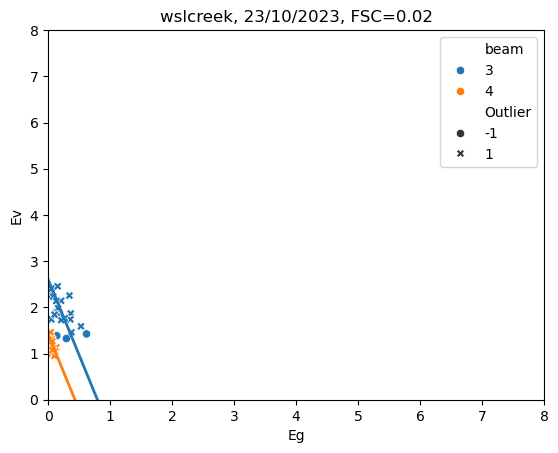

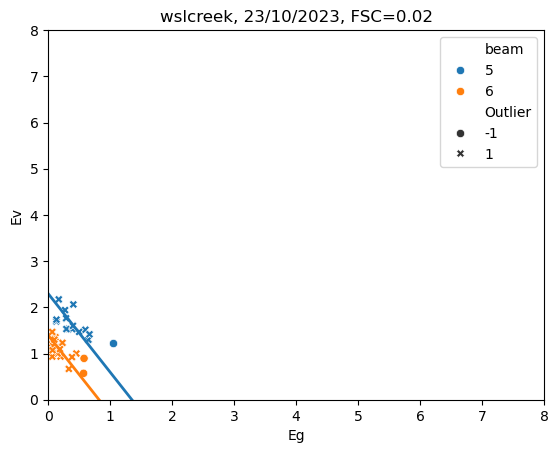

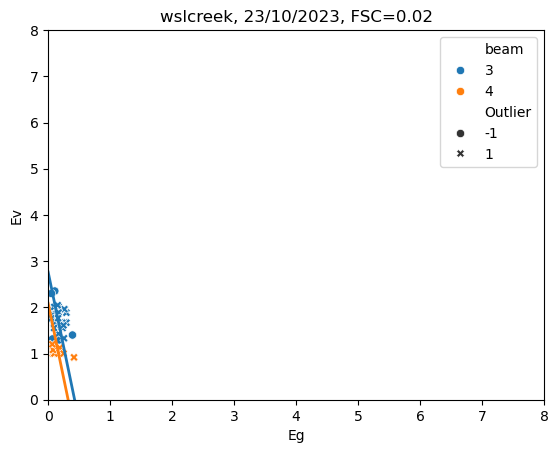

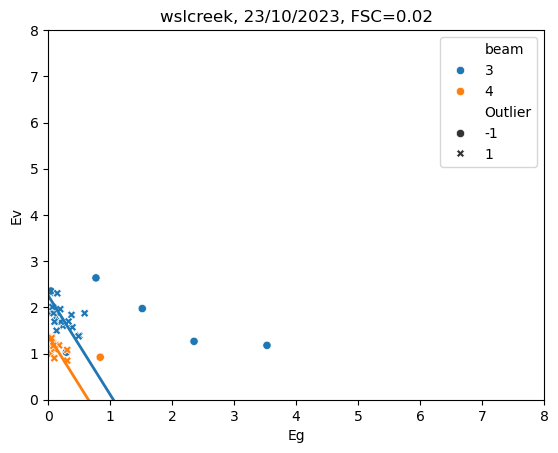

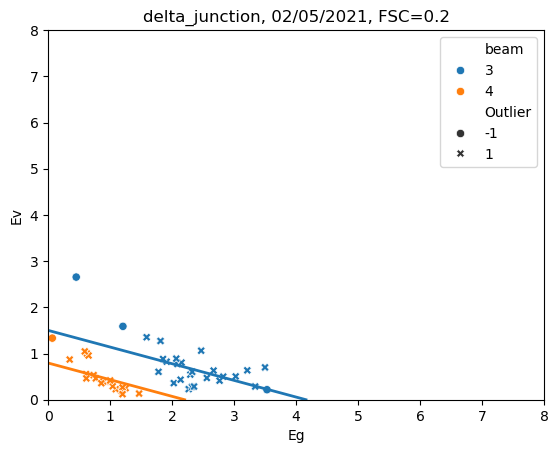

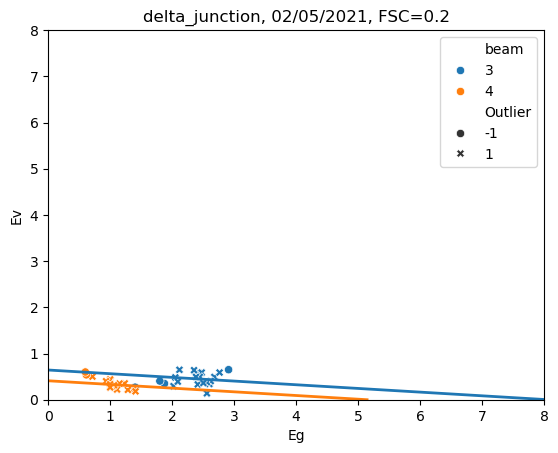

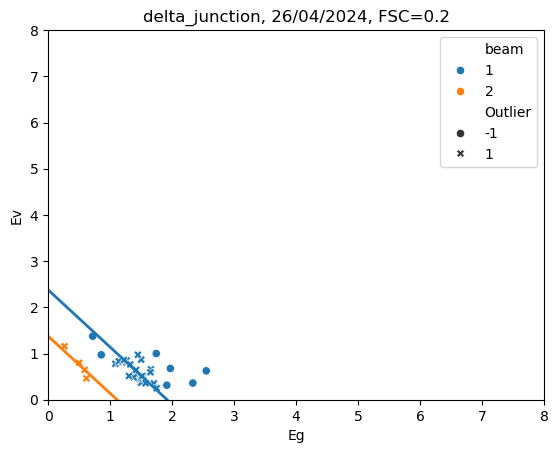

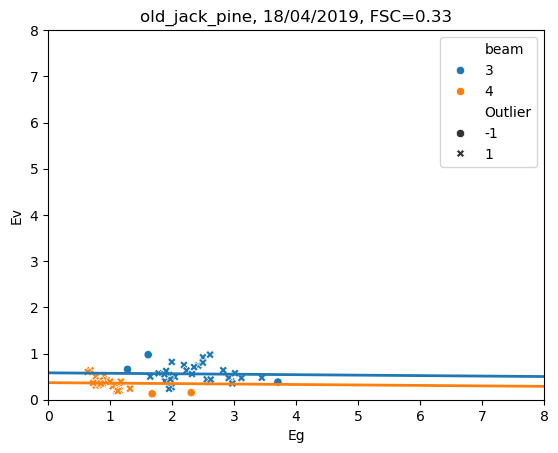

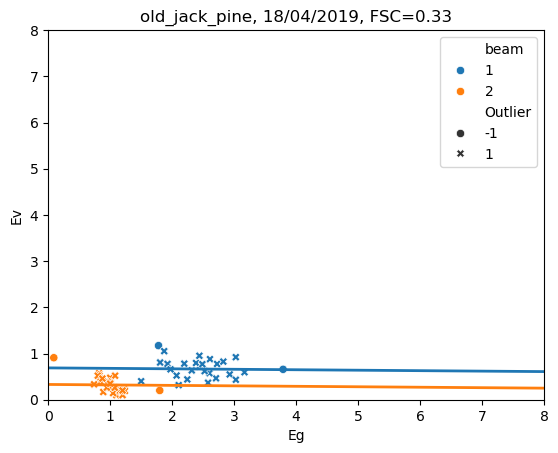

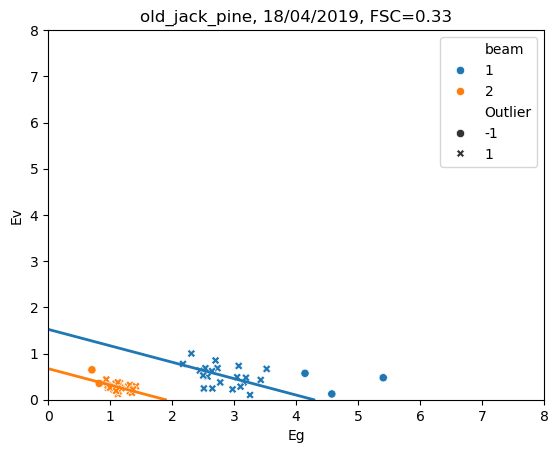

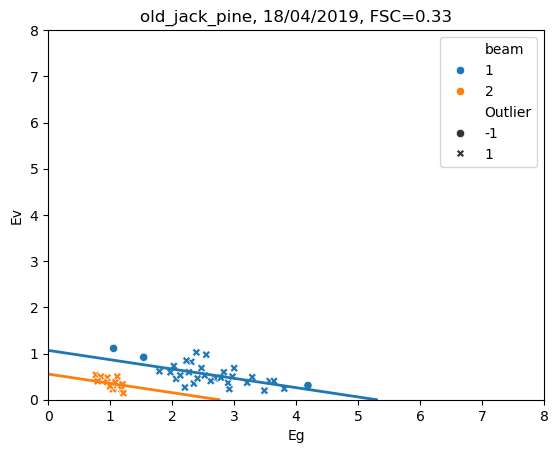

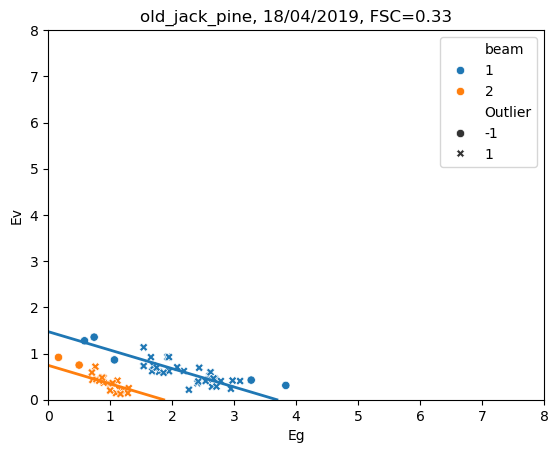

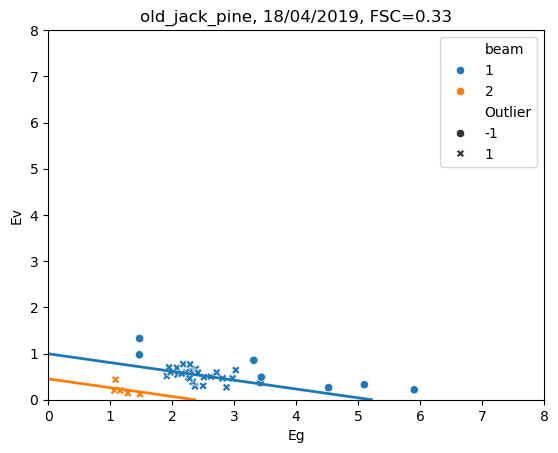

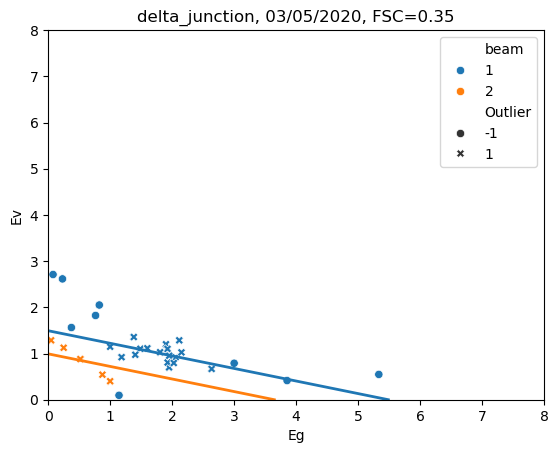

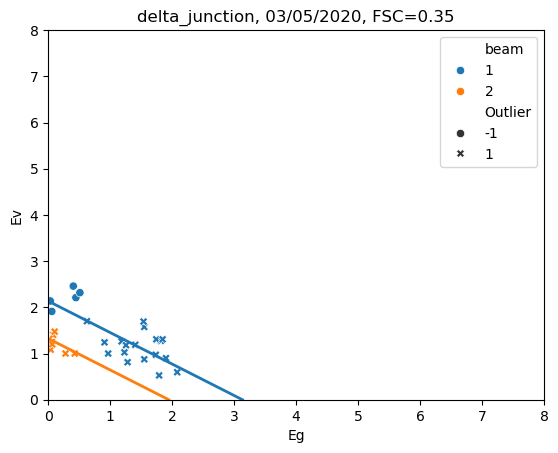

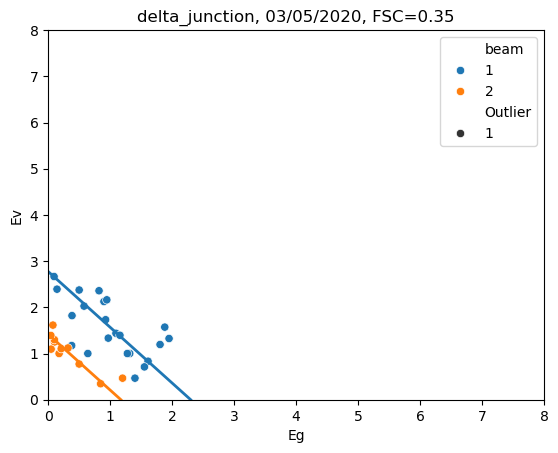

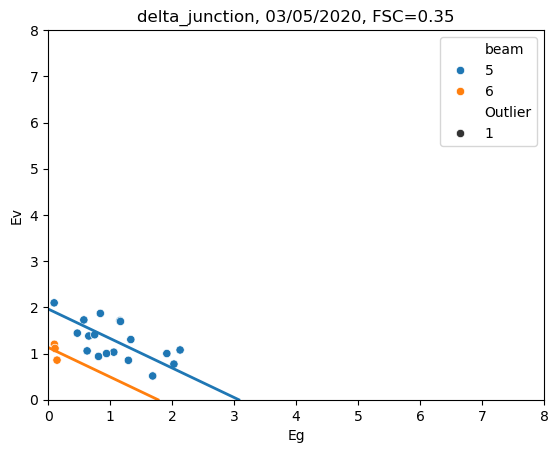

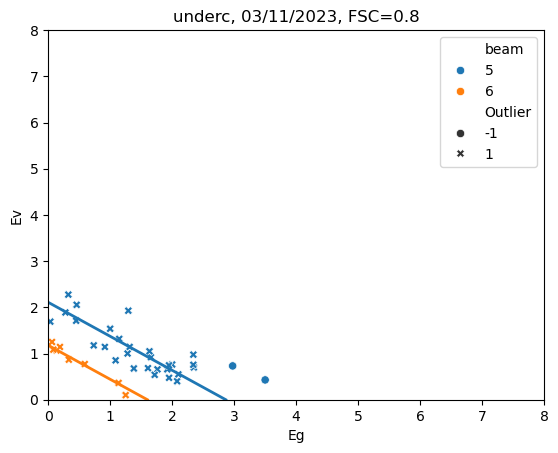

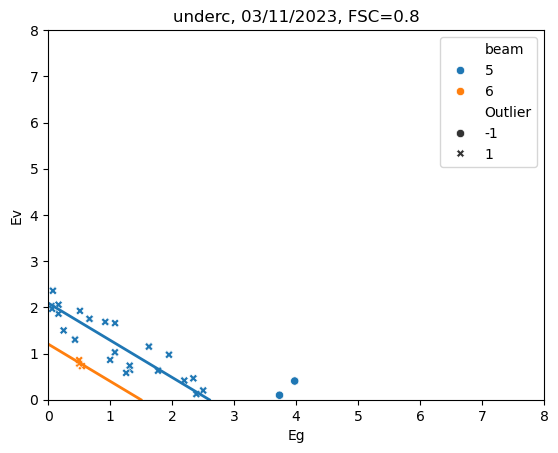

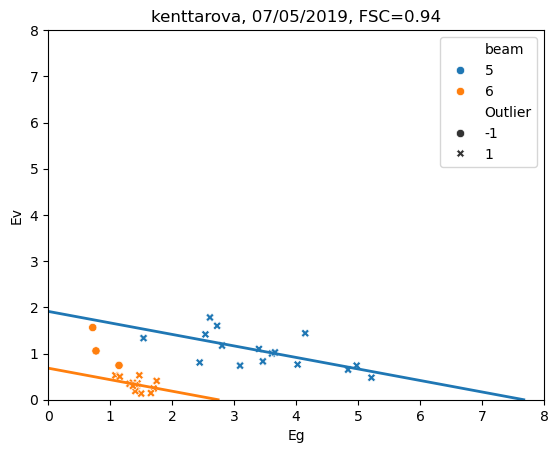

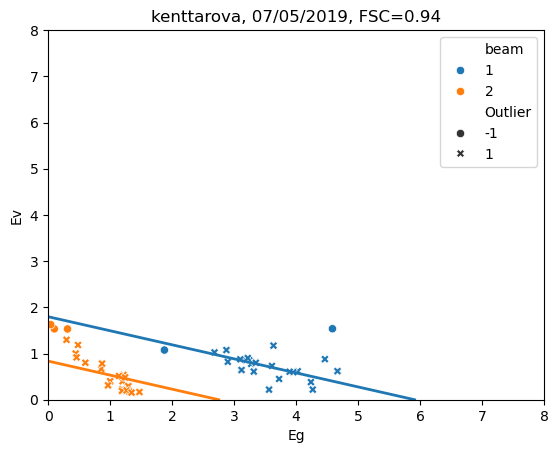

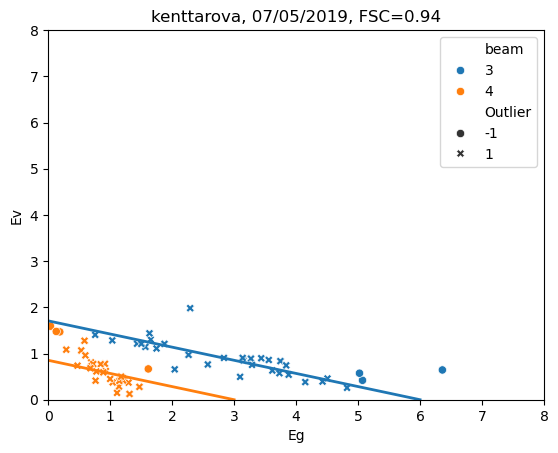

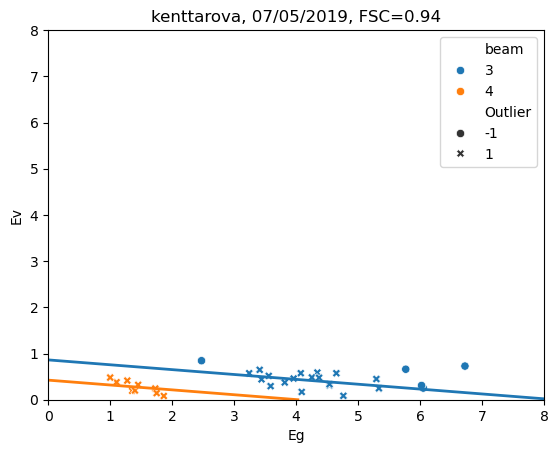

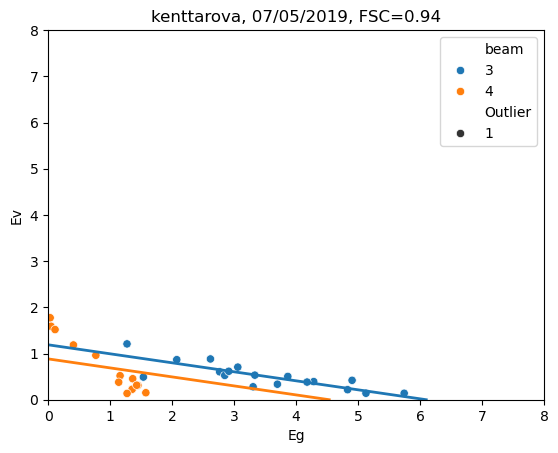

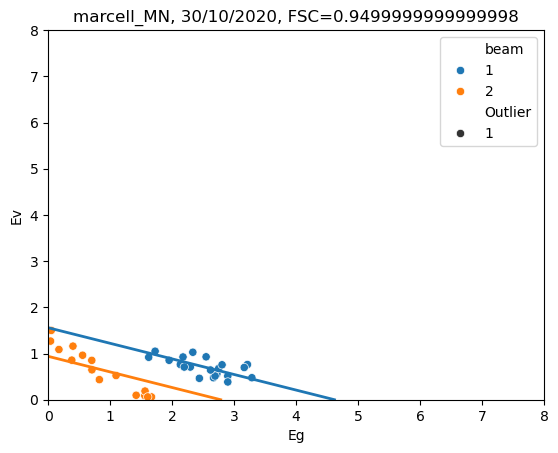

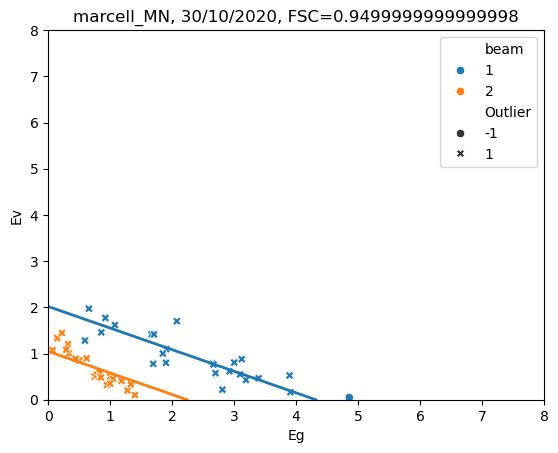

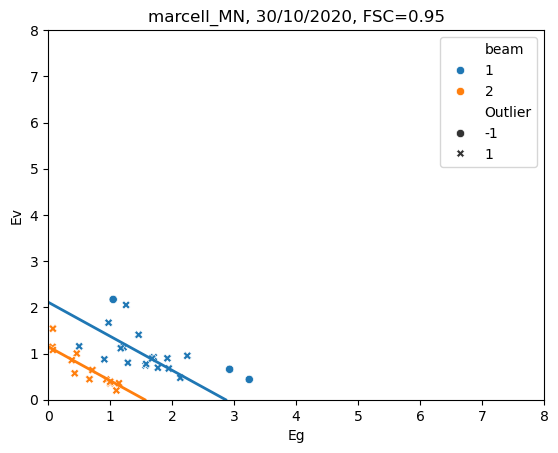

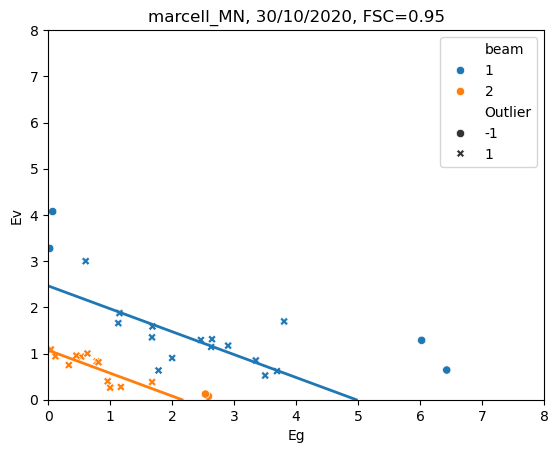

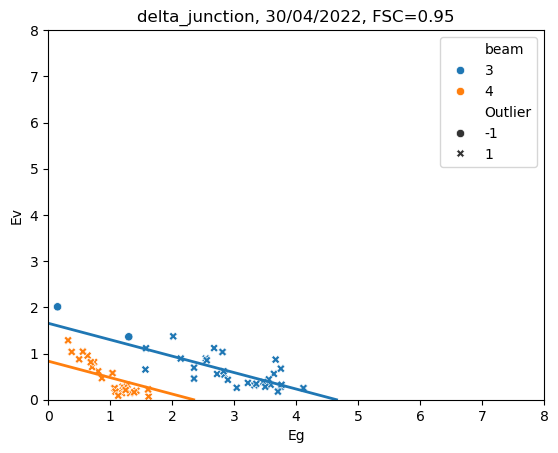

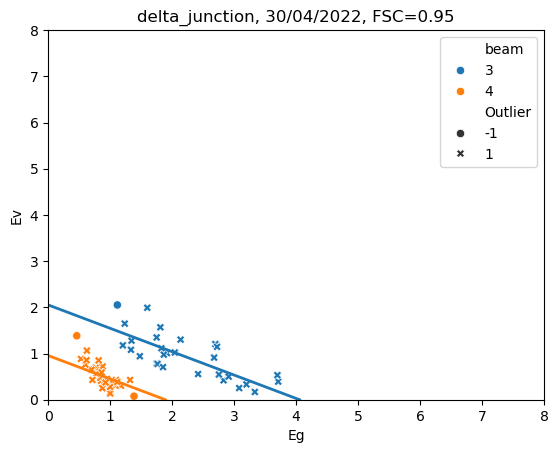

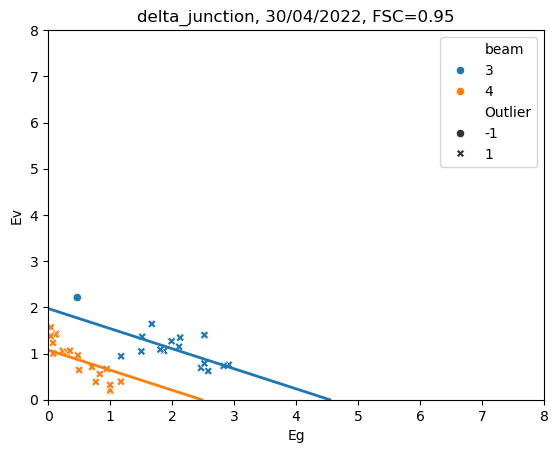

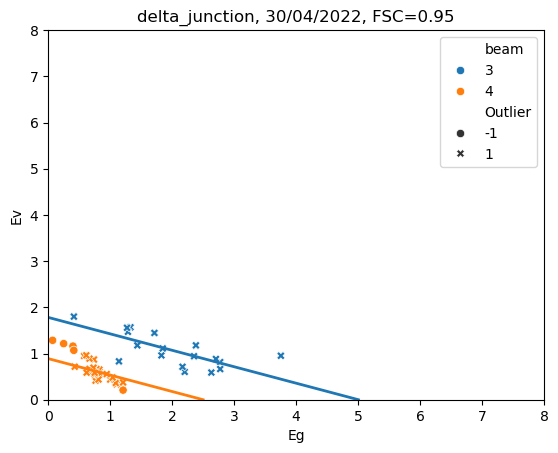

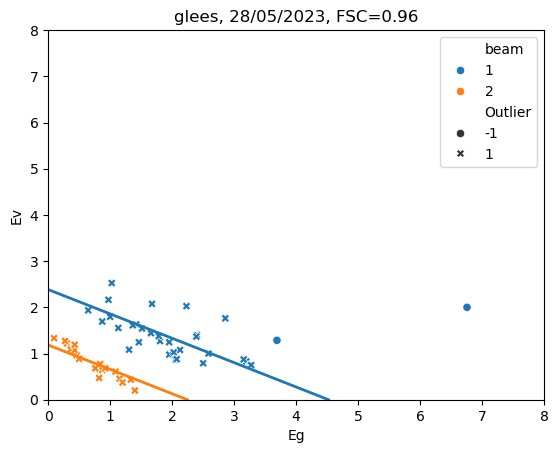

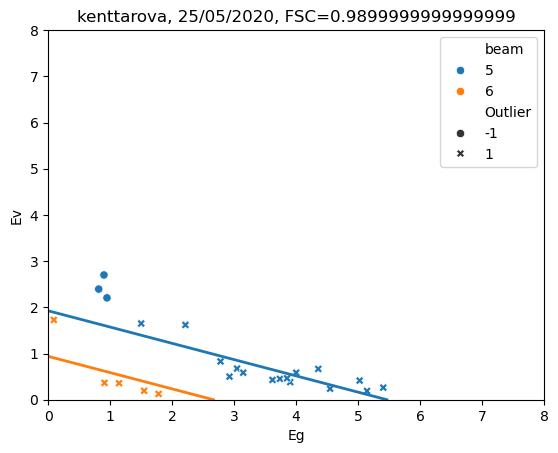

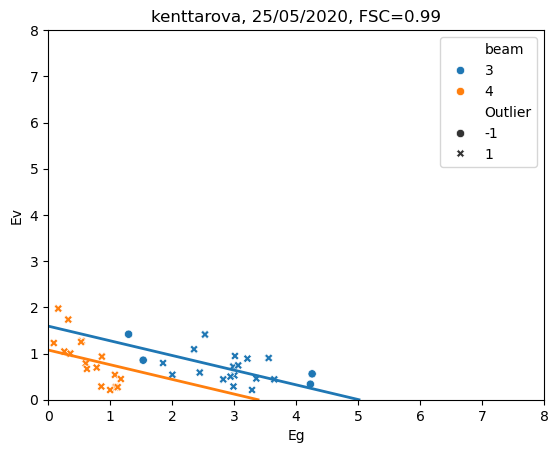

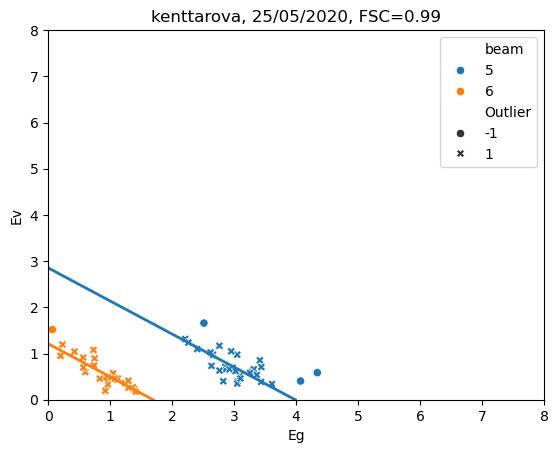

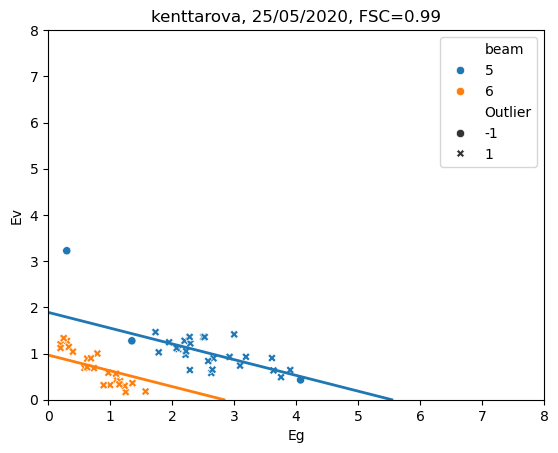

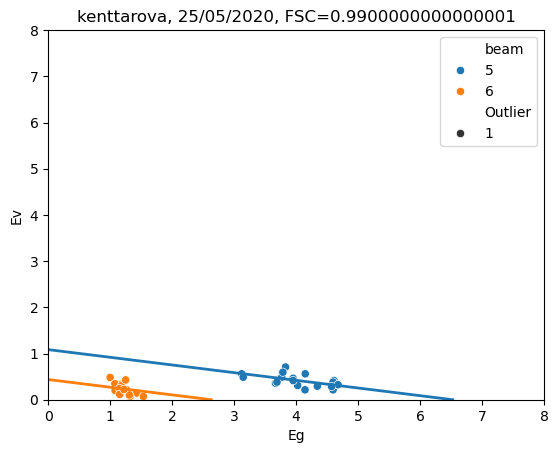

In [19]:
from scripts.parallel_blocks_WIP import *
    
# misclassified.columns
for idx, row in frac_data.sort_values('FSC').iterrows():
    plt.figure()
    plt.title(f"{row['camera']}, {row['date']}, FSC={row['FSC']}")
    
    test_plot = df[(df['camera'] == row['camera']) &
                   (df['date'] == row['date']) &
                   (df['lon'] == row['lon']) &
                   (df['lat'] == row['lat'])].copy()

    params, _, test = df_odr(test_plot, outlier_removal=10,w=[1, 0.25])

    # print(test)

    # Get sorted unique beams (hue order used by seaborn)
    beam_order = sorted(test['beam'].unique())

    # Create mapping from beam label to tab10 color
    tab10 = cm.get_cmap('tab10')
    color_map = {beam: tab10(i) for i, beam in enumerate(beam_order)}

    # Plot with fixed hue order and palette
    sns.scatterplot(data=test, x='Eg', y='Ev', hue='beam', style='Outlier',
                    hue_order=beam_order, palette=color_map)

    # Plot ODR lines in matching colors
    for b, beam in zip(params[1:], beam_order):
        plt.plot([0, -b / params[0]], [b, 0], color=color_map[beam], linewidth=2)

    plt.xlim(0, 8)
    plt.ylim(0, 8)
    plt.legend()
    plt.show()

    # break